In [1]:
# =================================
# COMP0078 Coursework 2 Q1.5 RE1.2
# Douglas Chiang
# 15055142
# =================================
cd /Users/DouglasChiang/Google Drive_HNC/Colab Notebooks/COMP0078/CW2/Q1

/Users/DouglasChiang/Google Drive_HNC/Colab Notebooks/COMP0078/CW2/Q1


In [2]:
ls

Assignment_2_Question_1a_v3.ipynb    assignment_2_question_1f_1_v1.py
Assignment_2_Question_1e_2_v1.ipynb  dtest123.dat*
Icon?                                dtrain123.dat*
Plots/                               zipcombo.dat*
Q1 Trial.ipynb


Libraries:

In [3]:
import time
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
from multiprocessing import Pool

Functions for data

In [4]:
def load_dat(fname, Full_Data = False):
    dat = pd.read_csv(fname, sep='\s+', header=None).to_numpy()
    if Full_Data == False:
        y = dat[:, 0].astype(np.int) - 1  # we are zero-based indexing
    else:
        y = dat[:, 0].astype(np.int)
    
    X = dat[:, 1:].astype(np.float64)
    return X, y

def Plot_Accuracy_SV(Ker_para, run, n_epochs, Train_accuracy_All, Test_accuracy_All):
    fig1, ax1 = plt.subplots()

    ax1.plot(range(1, n_epochs), Train_accuracy_All, color='red', label='Training accuracy')
    ax1.plot(range(1, n_epochs), Test_accuracy_All, color='blue', label='Testing accuracy')

    plt.xlabel('Epoch(s)')
    leg = ax1.legend(bbox_to_anchor=(1.5, 1.02), loc='upper right', frameon=False)
    plt.savefig(f"/content/drive/MyDrive/Colab Notebooks/COMP0078/CW2/Q1/Plots/Q1a/d_{Ker_para}_run_{run}_Accuracy_SV.png")

def kFold(data_idx, fold, folds):
    # Return split data indices sets for k-fold validation
    
    if fold > folds - 1:
        raise Exception('fold number exceeds total folds available')
    
    m        = len(data_idx)
    size     = m // folds
    data_validate_idx = data_idx[fold*size:(fold + 1)*size]

    if fold == 0:
        # first fold
        data_train_idx = data_idx[(fold+1)*size:]

    elif fold == folds - 1:
        # last fold
        data_train_idx = data_idx[:fold*size]

    else:
        # middle fold
        data_train1_idx = data_idx[:fold*size]
        data_train2_idx = data_idx[(fold+1)*size:]
        data_train_idx  = np.concatenate((data_train1_idx, data_train2_idx), axis=0)
    
    return data_train_idx, data_validate_idx

Kernel Calculation

In [5]:
class KernelFunctor:
    """
    Calculate the Kernel values and put them in a matrix
    """
    def __init__(self, Ker_Meth="Poly", Ker_para=2):
        self.Ker_Meth = Ker_Meth
        self.Ker_para = Ker_para
        #self.X_idx = 
    
    def kernel_fn(self, X):
        if self.Ker_Meth == "Poly":
            return (X.dot(X.T))**self.Ker_para
        elif self.Ker_Meth == "Gau":
            mi = X.shape[0]
            mj = X.shape[0]
            
            xi2 = np.sum(X ** 2, axis=1)
            xj2 = np.sum(X ** 2, axis=1)
            
            xi2 = xi2.reshape((mi, 1))
            xj2 = xj2.reshape((1, mj))
            
            K = xi2 + xj2 - 2 * X.dot(X.T)
            K = np.exp(-self.Ker_para*K)

            return K
        else:
            assert False, "Kernel Method Undefined"

K - Class Classifier: One vs Rest Online Perceptron


In [6]:
class OvR_OnlinePerceptron:
    """
    One-vs-Rest
    """
    def __init__(self, alphas, kernel_matrix, n_classes=3):
        self.alphas              = alphas
        self.kernel_matrix       = kernel_matrix
        self.alphas              = alphas
        self.n_classes           = n_classes

    def fit(self, ran_train_sample_idx, X, y):
        n_samples, n_dim = X.shape

        # record down data
        self.n_dim                = n_dim
        self.n_samples            = range(n_samples)
        self.ran_train_sample_idx = ran_train_sample_idx
        # ------------------------------------------------------
        for i in self.n_samples:
            cls_vals           = self._get_classifier_vals(self.ran_train_sample_idx[i])
            preds              = self.sign(cls_vals)
            truth              = self._label_to_custom_onehot(y[i])
            self.alphas[:, i] -= np.where(np.multiply(cls_vals, truth) <= 0, preds, 0)

        return self.alphas

    def _get_classifier_vals(self, sample_idx):
        """
        This is the classifier:
        .. math::
            w(x) = \sum_i \alpha_i K(x_i, x)
        Args:
            x (np.ndarray): the input feature you would like to classify
        Return:
            An array of size (n_classes,). Each value represents the inner product
            sum between support vectors of a classifier and the incoming feature.
        """
        ret           = np.zeros((self.n_classes,))
        kernel_values = self.kernel_matrix[self.ran_train_sample_idx, sample_idx]
        ret          += self.alphas.dot(kernel_values)
        assert ret.shape == (self.n_classes,)
        return ret

    def predict(self, sample_idx):
        cls_vals = self._get_classifier_vals(sample_idx)
        return np.argmax(cls_vals)

    @staticmethod
    def sign(val):
        ret = np.where(val <= 0.0, -1, 1)
        return ret

    def _label_to_custom_onehot(self, label: int):
        """
        Similar to one-hot encoding, we mark the truth one as 1, otherwise -1
        Example:
        >>> ovrop = OvR_OnlinePerceptron(n_classes=5)
        >>> ovrop._label_to_custom_onehot(2)
        [-1, -1, 1, -1, -1]
        >>> ovrop._label_to_custom_onehot(4)
        [-1, -1, -1, -1, 1]
        """
        ret = np.full((self.n_classes,), -1)
        ret[label] = 1
        return ret

In [7]:
# Trial data set:
# X_train, y_train = load_dat("dtrain123.dat", Full_Data = False)
# X_test, y_test   = load_dat("dtest123.dat", Full_Data = False)
# X_dataset = np.vstack((X_train, X_test))
# Y_dataset = np.hstack((y_train, y_test))

# Full data set:
X_dataset, Y_dataset = load_dat("zipcombo.dat", Full_Data = True)
# split_pt = round(X_dataset.shape[0]*0.1)
# X_dataset = X_dataset[:split_pt]
# Y_dataset = Y_dataset[:split_pt]

Run: 1
c = 0.007
Precalculate Kernel...
**Kernel calculation finished in 6.4349 seconds
fold: 1
**Training: Epoch 1 finished in 7.2956 seconds
**Training: Epoch 2 finished in 6.6465 seconds
**Training: Epoch 3 finished in 6.7885 seconds
**Training: Epoch 4 finished in 6.7116 seconds
**Training: Epoch 5 finished in 7.6826 seconds
**Training: Epoch 6 finished in 7.9928 seconds
**Training: Epoch 7 finished in 5.9808 seconds
**Training: Epoch 8 finished in 7.6576 seconds
**Training: Epoch 9 finished in 7.7574 seconds
**Training: Epoch 10 finished in 8.7046 seconds
**Training: Epoch 11 finished in 7.6932 seconds
**Training: Epoch 12 finished in 8.7426 seconds
**Training: Epoch 13 finished in 6.2799 seconds
**Training: Epoch 14 finished in 6.5114 seconds
**Training: Epoch 15 finished in 6.9016 seconds
**Training: Epoch 16 finished in 6.5425 seconds
**Training: Epoch 17 finished in 6.3023 seconds
**Training: Epoch 18 finished in 6.2837 seconds
**Training: Epoch 19 finished in 6.6534 seconds
*

**Training: Epoch 9 finished in 9.0233 seconds
**Training: Epoch 10 finished in 6.0592 seconds
**Training: Epoch 11 finished in 6.2773 seconds
**Training: Epoch 12 finished in 6.0603 seconds
**Training: Epoch 13 finished in 6.0010 seconds
**Training: Epoch 14 finished in 6.7620 seconds
**Training: Epoch 15 finished in 6.2539 seconds
**Training: Epoch 16 finished in 6.1409 seconds
**Training: Epoch 17 finished in 6.2221 seconds
**Training: Epoch 18 finished in 6.1113 seconds
**Training: Epoch 19 finished in 6.2153 seconds
**Training: Epoch 20 finished in 6.5056 seconds
fold: 5
**Training: Epoch 1 finished in 6.8844 seconds
**Training: Epoch 2 finished in 6.2531 seconds
**Training: Epoch 3 finished in 5.9752 seconds
**Training: Epoch 4 finished in 6.1208 seconds
**Training: Epoch 5 finished in 6.4206 seconds
**Training: Epoch 6 finished in 4.2439 seconds
**Training: Epoch 7 finished in 2.2846 seconds
**Training: Epoch 8 finished in 2.4094 seconds
**Training: Epoch 9 finished in 4.8114 se

**Training: Epoch 17 finished in 9.4930 seconds
**Training: Epoch 18 finished in 9.1897 seconds
**Training: Epoch 19 finished in 9.1724 seconds
**Training: Epoch 20 finished in 7.0563 seconds
fold: 3
**Training: Epoch 1 finished in 6.4768 seconds
**Training: Epoch 2 finished in 6.0243 seconds
**Training: Epoch 3 finished in 6.1337 seconds
**Training: Epoch 4 finished in 6.2211 seconds
**Training: Epoch 5 finished in 5.9716 seconds
**Training: Epoch 6 finished in 6.7609 seconds
**Training: Epoch 7 finished in 6.3282 seconds
**Training: Epoch 8 finished in 6.1844 seconds
**Training: Epoch 9 finished in 6.0734 seconds
**Training: Epoch 10 finished in 6.3506 seconds
**Training: Epoch 11 finished in 6.2456 seconds
**Training: Epoch 12 finished in 6.6157 seconds
**Training: Epoch 13 finished in 7.4454 seconds
**Training: Epoch 14 finished in 6.0875 seconds
**Training: Epoch 15 finished in 6.1047 seconds
**Training: Epoch 16 finished in 6.9761 seconds
**Training: Epoch 17 finished in 9.7704 s

**Training: Epoch 5 finished in 8.1268 seconds
**Training: Epoch 6 finished in 6.5375 seconds
**Training: Epoch 7 finished in 6.1451 seconds
**Training: Epoch 8 finished in 5.9477 seconds
**Training: Epoch 9 finished in 6.3380 seconds
**Training: Epoch 10 finished in 6.0508 seconds
**Training: Epoch 11 finished in 6.5697 seconds
**Training: Epoch 12 finished in 6.1788 seconds
**Training: Epoch 13 finished in 6.0558 seconds
**Training: Epoch 14 finished in 5.9290 seconds
**Training: Epoch 15 finished in 6.3263 seconds
**Training: Epoch 16 finished in 6.2985 seconds
**Training: Epoch 17 finished in 6.2532 seconds
**Training: Epoch 18 finished in 8.2597 seconds
**Training: Epoch 19 finished in 7.2080 seconds
**Training: Epoch 20 finished in 5.9097 seconds
fold: 2
**Training: Epoch 1 finished in 7.0686 seconds
**Training: Epoch 2 finished in 6.0880 seconds
**Training: Epoch 3 finished in 6.1844 seconds
**Training: Epoch 4 finished in 6.0943 seconds
**Training: Epoch 5 finished in 5.7753 se

**Training: Epoch 15 finished in 5.9002 seconds
**Training: Epoch 16 finished in 5.9929 seconds
**Training: Epoch 17 finished in 6.0229 seconds
**Training: Epoch 18 finished in 6.2348 seconds
**Training: Epoch 19 finished in 6.6252 seconds
**Training: Epoch 20 finished in 6.1227 seconds
fold: 5
**Training: Epoch 1 finished in 6.1586 seconds
**Training: Epoch 2 finished in 6.0098 seconds
**Training: Epoch 3 finished in 6.1072 seconds
**Training: Epoch 4 finished in 6.1606 seconds
**Training: Epoch 5 finished in 6.1690 seconds
**Training: Epoch 6 finished in 6.1224 seconds
**Training: Epoch 7 finished in 6.3448 seconds
**Training: Epoch 8 finished in 6.0556 seconds
**Training: Epoch 9 finished in 6.0573 seconds
**Training: Epoch 10 finished in 6.0030 seconds
**Training: Epoch 11 finished in 6.4462 seconds
**Training: Epoch 12 finished in 6.0350 seconds
**Training: Epoch 13 finished in 6.5635 seconds
**Training: Epoch 14 finished in 6.0794 seconds
**Training: Epoch 15 finished in 6.1002 s

**Training: Epoch 3 finished in 6.7974 seconds
**Training: Epoch 4 finished in 6.1301 seconds
**Training: Epoch 5 finished in 6.0819 seconds
**Training: Epoch 6 finished in 6.1276 seconds
**Training: Epoch 7 finished in 6.2960 seconds
**Training: Epoch 8 finished in 5.8898 seconds
**Training: Epoch 9 finished in 6.2242 seconds
**Training: Epoch 10 finished in 6.1169 seconds
**Training: Epoch 11 finished in 5.9620 seconds
**Training: Epoch 12 finished in 6.1566 seconds
**Training: Epoch 13 finished in 7.5151 seconds
**Training: Epoch 14 finished in 7.9441 seconds
**Training: Epoch 15 finished in 6.2897 seconds
**Training: Epoch 16 finished in 7.0006 seconds
**Training: Epoch 17 finished in 6.3745 seconds
**Training: Epoch 18 finished in 6.1673 seconds
**Training: Epoch 19 finished in 6.1965 seconds
**Training: Epoch 20 finished in 6.1532 seconds
fold: 4
**Training: Epoch 1 finished in 6.1134 seconds
**Training: Epoch 2 finished in 6.4489 seconds
**Training: Epoch 3 finished in 6.4408 se

**Training: Epoch 11 finished in 5.9755 seconds
**Training: Epoch 12 finished in 6.6602 seconds
**Training: Epoch 13 finished in 6.1744 seconds
**Training: Epoch 14 finished in 5.7972 seconds
**Training: Epoch 15 finished in 6.0691 seconds
**Training: Epoch 16 finished in 6.0819 seconds
**Training: Epoch 17 finished in 6.4122 seconds
**Training: Epoch 18 finished in 6.6988 seconds
**Training: Epoch 19 finished in 6.2109 seconds
**Training: Epoch 20 finished in 6.1502 seconds
fold: 2
**Training: Epoch 1 finished in 5.8875 seconds
**Training: Epoch 2 finished in 4.6597 seconds
**Training: Epoch 3 finished in 2.4549 seconds
**Training: Epoch 4 finished in 2.3060 seconds
**Training: Epoch 5 finished in 5.8448 seconds
**Training: Epoch 6 finished in 6.3039 seconds
**Training: Epoch 7 finished in 6.0164 seconds
**Training: Epoch 8 finished in 6.0239 seconds
**Training: Epoch 9 finished in 6.4746 seconds
**Training: Epoch 10 finished in 6.2534 seconds
**Training: Epoch 11 finished in 6.1126 s

**Training: Epoch 18 finished in 6.1479 seconds
**Training: Epoch 19 finished in 6.1346 seconds
**Training: Epoch 20 finished in 6.2041 seconds
fold: 4
**Training: Epoch 1 finished in 6.0661 seconds
**Training: Epoch 2 finished in 9.6442 seconds
**Training: Epoch 3 finished in 6.6369 seconds
**Training: Epoch 4 finished in 6.1330 seconds
**Training: Epoch 5 finished in 5.9213 seconds
**Training: Epoch 6 finished in 6.0433 seconds
**Training: Epoch 7 finished in 5.9422 seconds
**Training: Epoch 8 finished in 6.4262 seconds
**Training: Epoch 9 finished in 6.0924 seconds
**Training: Epoch 10 finished in 5.9799 seconds
**Training: Epoch 11 finished in 5.9844 seconds
**Training: Epoch 12 finished in 6.0454 seconds
**Training: Epoch 13 finished in 6.1105 seconds
**Training: Epoch 14 finished in 6.0342 seconds
**Training: Epoch 15 finished in 5.9846 seconds
**Training: Epoch 16 finished in 6.3702 seconds
**Training: Epoch 17 finished in 6.1395 seconds
**Training: Epoch 18 finished in 6.0865 s

**Training: Epoch 6 finished in 6.1508 seconds
**Training: Epoch 7 finished in 6.6785 seconds
**Training: Epoch 8 finished in 6.0603 seconds
**Training: Epoch 9 finished in 5.9632 seconds
**Training: Epoch 10 finished in 6.3020 seconds
**Training: Epoch 11 finished in 5.9292 seconds
**Training: Epoch 12 finished in 6.1849 seconds
**Training: Epoch 13 finished in 6.2400 seconds
**Training: Epoch 14 finished in 9.2203 seconds
**Training: Epoch 15 finished in 6.7645 seconds
**Training: Epoch 16 finished in 6.1092 seconds
**Training: Epoch 17 finished in 5.9854 seconds
**Training: Epoch 18 finished in 6.1287 seconds
**Training: Epoch 19 finished in 6.2490 seconds
**Training: Epoch 20 finished in 6.1887 seconds
fold: 3
**Training: Epoch 1 finished in 6.4947 seconds
**Training: Epoch 2 finished in 5.9901 seconds
**Training: Epoch 3 finished in 6.0801 seconds
**Training: Epoch 4 finished in 6.0827 seconds
**Training: Epoch 5 finished in 5.9718 seconds
**Training: Epoch 6 finished in 5.9709 se

**Training: Epoch 16 finished in 6.0751 seconds
**Training: Epoch 17 finished in 6.2392 seconds
**Training: Epoch 18 finished in 6.0720 seconds
**Training: Epoch 19 finished in 6.0892 seconds
**Training: Epoch 20 finished in 6.1628 seconds
c = 0.0078
Precalculate Kernel...
**Kernel calculation finished in 6.8136 seconds
fold: 1
**Training: Epoch 1 finished in 6.3014 seconds
**Training: Epoch 2 finished in 6.1273 seconds
**Training: Epoch 3 finished in 6.0209 seconds
**Training: Epoch 4 finished in 6.2979 seconds
**Training: Epoch 5 finished in 6.1760 seconds
**Training: Epoch 6 finished in 6.0855 seconds
**Training: Epoch 7 finished in 6.2076 seconds
**Training: Epoch 8 finished in 5.9191 seconds
**Training: Epoch 9 finished in 5.9518 seconds
**Training: Epoch 10 finished in 5.9831 seconds
**Training: Epoch 11 finished in 6.0125 seconds
**Training: Epoch 12 finished in 6.3036 seconds
**Training: Epoch 13 finished in 6.1496 seconds
**Training: Epoch 14 finished in 6.0646 seconds
**Train

**Training: Epoch 4 finished in 6.1672 seconds
**Training: Epoch 5 finished in 6.0161 seconds
**Training: Epoch 6 finished in 5.9084 seconds
**Training: Epoch 7 finished in 5.9977 seconds
**Training: Epoch 8 finished in 5.9518 seconds
**Training: Epoch 9 finished in 6.1675 seconds
**Training: Epoch 10 finished in 6.0650 seconds
**Training: Epoch 11 finished in 6.1179 seconds
**Training: Epoch 12 finished in 6.0975 seconds
**Training: Epoch 13 finished in 6.0084 seconds
**Training: Epoch 14 finished in 6.0581 seconds
**Training: Epoch 15 finished in 6.2292 seconds
**Training: Epoch 16 finished in 6.0467 seconds
**Training: Epoch 17 finished in 5.9845 seconds
**Training: Epoch 18 finished in 6.1122 seconds
**Training: Epoch 19 finished in 6.0123 seconds
**Training: Epoch 20 finished in 6.0394 seconds
fold: 5
**Training: Epoch 1 finished in 6.1338 seconds
**Training: Epoch 2 finished in 6.0273 seconds
**Training: Epoch 3 finished in 6.3711 seconds
**Training: Epoch 4 finished in 5.9507 se

**Training: Epoch 12 finished in 6.1199 seconds
**Training: Epoch 13 finished in 5.9980 seconds
**Training: Epoch 14 finished in 5.9462 seconds
**Training: Epoch 15 finished in 6.2570 seconds
**Training: Epoch 16 finished in 5.9325 seconds
**Training: Epoch 17 finished in 6.0255 seconds
**Training: Epoch 18 finished in 5.9092 seconds
**Training: Epoch 19 finished in 6.2712 seconds
**Training: Epoch 20 finished in 5.9595 seconds
fold: 3
**Training: Epoch 1 finished in 5.9068 seconds
**Training: Epoch 2 finished in 6.0509 seconds
**Training: Epoch 3 finished in 6.2344 seconds
**Training: Epoch 4 finished in 6.1134 seconds
**Training: Epoch 5 finished in 6.2895 seconds
**Training: Epoch 6 finished in 5.9944 seconds
**Training: Epoch 7 finished in 6.0132 seconds
**Training: Epoch 8 finished in 5.9586 seconds
**Training: Epoch 9 finished in 5.9560 seconds
**Training: Epoch 10 finished in 5.9420 seconds
**Training: Epoch 11 finished in 5.9798 seconds
**Training: Epoch 12 finished in 6.3503 s

**Kernel calculation finished in 6.2231 seconds
fold: 1
**Training: Epoch 1 finished in 2.3481 seconds
**Training: Epoch 2 finished in 2.3982 seconds
**Training: Epoch 3 finished in 4.1500 seconds
**Training: Epoch 4 finished in 6.1419 seconds
**Training: Epoch 5 finished in 5.9700 seconds
**Training: Epoch 6 finished in 6.2674 seconds
**Training: Epoch 7 finished in 6.0337 seconds
**Training: Epoch 8 finished in 5.9489 seconds
**Training: Epoch 9 finished in 6.5201 seconds
**Training: Epoch 10 finished in 6.3674 seconds
**Training: Epoch 11 finished in 6.1036 seconds
**Training: Epoch 12 finished in 6.1406 seconds
**Training: Epoch 13 finished in 7.4212 seconds
**Training: Epoch 14 finished in 6.0108 seconds
**Training: Epoch 15 finished in 6.1216 seconds
**Training: Epoch 16 finished in 6.6707 seconds
**Training: Epoch 17 finished in 6.2037 seconds
**Training: Epoch 18 finished in 6.1480 seconds
**Training: Epoch 19 finished in 6.4425 seconds
**Training: Epoch 20 finished in 6.1785 s

**Training: Epoch 10 finished in 6.0821 seconds
**Training: Epoch 11 finished in 5.9725 seconds
**Training: Epoch 12 finished in 5.9395 seconds
**Training: Epoch 13 finished in 6.2004 seconds
**Training: Epoch 14 finished in 5.9352 seconds
**Training: Epoch 15 finished in 6.5790 seconds
**Training: Epoch 16 finished in 6.0694 seconds
**Training: Epoch 17 finished in 6.1765 seconds
**Training: Epoch 18 finished in 6.0305 seconds
**Training: Epoch 19 finished in 5.9398 seconds
**Training: Epoch 20 finished in 6.1504 seconds
fold: 5
**Training: Epoch 1 finished in 5.9544 seconds
**Training: Epoch 2 finished in 5.9418 seconds
**Training: Epoch 3 finished in 5.9792 seconds
**Training: Epoch 4 finished in 5.9377 seconds
**Training: Epoch 5 finished in 6.2979 seconds
**Training: Epoch 6 finished in 6.1864 seconds
**Training: Epoch 7 finished in 5.8020 seconds
**Training: Epoch 8 finished in 5.9560 seconds
**Training: Epoch 9 finished in 6.0822 seconds
**Training: Epoch 10 finished in 6.0284 s

**Training: Epoch 15 finished in 5.9365 seconds
**Training: Epoch 16 finished in 6.0719 seconds
**Training: Epoch 17 finished in 6.3294 seconds
**Training: Epoch 18 finished in 5.8749 seconds
**Training: Epoch 19 finished in 6.2020 seconds
**Training: Epoch 20 finished in 6.2923 seconds
fold: 2
**Training: Epoch 1 finished in 6.1244 seconds
**Training: Epoch 2 finished in 6.1738 seconds
**Training: Epoch 3 finished in 6.4728 seconds
**Training: Epoch 4 finished in 6.4900 seconds
**Training: Epoch 5 finished in 5.9732 seconds
**Training: Epoch 6 finished in 6.2359 seconds
**Training: Epoch 7 finished in 6.1419 seconds
**Training: Epoch 8 finished in 6.0109 seconds
**Training: Epoch 9 finished in 6.1523 seconds
**Training: Epoch 10 finished in 6.0242 seconds
**Training: Epoch 11 finished in 6.1164 seconds
**Training: Epoch 12 finished in 6.1076 seconds
**Training: Epoch 13 finished in 6.0486 seconds
**Training: Epoch 14 finished in 6.4901 seconds
**Training: Epoch 15 finished in 5.9395 s

**Training: Epoch 5 finished in 5.8809 seconds
**Training: Epoch 6 finished in 6.2749 seconds
**Training: Epoch 7 finished in 6.0754 seconds
**Training: Epoch 8 finished in 6.2056 seconds
**Training: Epoch 9 finished in 6.0404 seconds
**Training: Epoch 10 finished in 7.2058 seconds
**Training: Epoch 11 finished in 6.2532 seconds
**Training: Epoch 12 finished in 6.1661 seconds
**Training: Epoch 13 finished in 6.3063 seconds
**Training: Epoch 14 finished in 5.9265 seconds
**Training: Epoch 15 finished in 6.0712 seconds
**Training: Epoch 16 finished in 6.1348 seconds
**Training: Epoch 17 finished in 5.8832 seconds
**Training: Epoch 18 finished in 6.0785 seconds
**Training: Epoch 19 finished in 6.1810 seconds
**Training: Epoch 20 finished in 5.9804 seconds
c = 0.0076
Precalculate Kernel...
**Kernel calculation finished in 5.8333 seconds
fold: 1
**Training: Epoch 1 finished in 6.0317 seconds
**Training: Epoch 2 finished in 7.7566 seconds
**Training: Epoch 3 finished in 9.0425 seconds
**Trai

**Training: Epoch 13 finished in 6.3552 seconds
**Training: Epoch 14 finished in 6.1269 seconds
**Training: Epoch 15 finished in 6.3679 seconds
**Training: Epoch 16 finished in 6.3123 seconds
**Training: Epoch 17 finished in 6.1496 seconds
**Training: Epoch 18 finished in 6.1637 seconds
**Training: Epoch 19 finished in 6.1117 seconds
**Training: Epoch 20 finished in 6.5005 seconds
fold: 4
**Training: Epoch 1 finished in 6.5828 seconds
**Training: Epoch 2 finished in 6.6131 seconds
**Training: Epoch 3 finished in 6.1514 seconds
**Training: Epoch 4 finished in 6.1857 seconds
**Training: Epoch 5 finished in 6.2839 seconds
**Training: Epoch 6 finished in 6.0251 seconds
**Training: Epoch 7 finished in 6.2831 seconds
**Training: Epoch 8 finished in 6.2240 seconds
**Training: Epoch 9 finished in 6.2668 seconds
**Training: Epoch 10 finished in 6.1223 seconds
**Training: Epoch 11 finished in 6.1407 seconds
**Training: Epoch 12 finished in 6.7247 seconds
**Training: Epoch 13 finished in 6.1426 s

fold: 2
**Training: Epoch 1 finished in 6.4185 seconds
**Training: Epoch 2 finished in 6.3014 seconds
**Training: Epoch 3 finished in 6.2241 seconds
**Training: Epoch 4 finished in 6.4016 seconds
**Training: Epoch 5 finished in 6.1993 seconds
**Training: Epoch 6 finished in 6.4891 seconds
**Training: Epoch 7 finished in 6.5293 seconds
**Training: Epoch 8 finished in 6.1870 seconds
**Training: Epoch 9 finished in 6.4573 seconds
**Training: Epoch 10 finished in 6.2118 seconds
**Training: Epoch 11 finished in 6.3267 seconds
**Training: Epoch 12 finished in 6.2082 seconds
**Training: Epoch 13 finished in 6.4608 seconds
**Training: Epoch 14 finished in 6.1897 seconds
**Training: Epoch 15 finished in 6.2027 seconds
**Training: Epoch 16 finished in 6.2445 seconds
**Training: Epoch 17 finished in 6.1536 seconds
**Training: Epoch 18 finished in 6.4220 seconds
**Training: Epoch 19 finished in 4.5125 seconds
**Training: Epoch 20 finished in 2.3777 seconds
fold: 3
**Training: Epoch 1 finished in 2

**Training: Epoch 11 finished in 6.6713 seconds
**Training: Epoch 12 finished in 6.6555 seconds
**Training: Epoch 13 finished in 6.8038 seconds
**Training: Epoch 14 finished in 6.6226 seconds
**Training: Epoch 15 finished in 6.5129 seconds
**Training: Epoch 16 finished in 6.6786 seconds
**Training: Epoch 17 finished in 6.4591 seconds
**Training: Epoch 18 finished in 5.9085 seconds
**Training: Epoch 19 finished in 6.8212 seconds
**Training: Epoch 20 finished in 6.6173 seconds
c = 0.0086
Precalculate Kernel...
**Kernel calculation finished in 6.1163 seconds
fold: 1
**Training: Epoch 1 finished in 6.4810 seconds
**Training: Epoch 2 finished in 6.9486 seconds
**Training: Epoch 3 finished in 9.3927 seconds
**Training: Epoch 4 finished in 6.7006 seconds
**Training: Epoch 5 finished in 6.5740 seconds
**Training: Epoch 6 finished in 6.5189 seconds
**Training: Epoch 7 finished in 6.5083 seconds
**Training: Epoch 8 finished in 6.7918 seconds
**Training: Epoch 9 finished in 6.5818 seconds
**Train

**Training: Epoch 19 finished in 6.4412 seconds
**Training: Epoch 20 finished in 6.2626 seconds
fold: 4
**Training: Epoch 1 finished in 6.3237 seconds
**Training: Epoch 2 finished in 6.1324 seconds
**Training: Epoch 3 finished in 6.2037 seconds
**Training: Epoch 4 finished in 6.3462 seconds
**Training: Epoch 5 finished in 6.4106 seconds
**Training: Epoch 6 finished in 6.2519 seconds
**Training: Epoch 7 finished in 6.5339 seconds
**Training: Epoch 8 finished in 6.0482 seconds
**Training: Epoch 9 finished in 6.3273 seconds
**Training: Epoch 10 finished in 6.4704 seconds
**Training: Epoch 11 finished in 6.3804 seconds
**Training: Epoch 12 finished in 6.1796 seconds
**Training: Epoch 13 finished in 6.5974 seconds
**Training: Epoch 14 finished in 6.2170 seconds
**Training: Epoch 15 finished in 6.4569 seconds
**Training: Epoch 16 finished in 6.1027 seconds
**Training: Epoch 17 finished in 6.3867 seconds
**Training: Epoch 18 finished in 6.2598 seconds
**Training: Epoch 19 finished in 6.1806 s

**Training: Epoch 4 finished in 6.3422 seconds
**Training: Epoch 5 finished in 6.1453 seconds
**Training: Epoch 6 finished in 6.3538 seconds
**Training: Epoch 7 finished in 6.0906 seconds
**Training: Epoch 8 finished in 6.0792 seconds
**Training: Epoch 9 finished in 6.7654 seconds
**Training: Epoch 10 finished in 6.3755 seconds
**Training: Epoch 11 finished in 6.5113 seconds
**Training: Epoch 12 finished in 6.1450 seconds
**Training: Epoch 13 finished in 6.2421 seconds
**Training: Epoch 14 finished in 6.4627 seconds
**Training: Epoch 15 finished in 6.6032 seconds
**Training: Epoch 16 finished in 6.1104 seconds
**Training: Epoch 17 finished in 9.4059 seconds
**Training: Epoch 18 finished in 7.2350 seconds
**Training: Epoch 19 finished in 6.1223 seconds
**Training: Epoch 20 finished in 6.1764 seconds
fold: 2
**Training: Epoch 1 finished in 6.4136 seconds
**Training: Epoch 2 finished in 6.0739 seconds
**Training: Epoch 3 finished in 6.5878 seconds
**Training: Epoch 4 finished in 6.2170 se

**Training: Epoch 14 finished in 10.1869 seconds
**Training: Epoch 15 finished in 8.5832 seconds
**Training: Epoch 16 finished in 6.4710 seconds
**Training: Epoch 17 finished in 6.4461 seconds
**Training: Epoch 18 finished in 6.4551 seconds
**Training: Epoch 19 finished in 6.2531 seconds
**Training: Epoch 20 finished in 6.1891 seconds
fold: 5
**Training: Epoch 1 finished in 6.5421 seconds
**Training: Epoch 2 finished in 6.3667 seconds
**Training: Epoch 3 finished in 6.2509 seconds
**Training: Epoch 4 finished in 6.2380 seconds
**Training: Epoch 5 finished in 6.3518 seconds
**Training: Epoch 6 finished in 6.1801 seconds
**Training: Epoch 7 finished in 6.4177 seconds
**Training: Epoch 8 finished in 6.4168 seconds
**Training: Epoch 9 finished in 6.1950 seconds
**Training: Epoch 10 finished in 6.2162 seconds
**Training: Epoch 11 finished in 6.2603 seconds
**Training: Epoch 12 finished in 6.1854 seconds
**Training: Epoch 13 finished in 7.2128 seconds
**Training: Epoch 14 finished in 6.2092 

**Training: Epoch 1 finished in 6.3149 seconds
**Training: Epoch 2 finished in 6.5045 seconds
**Training: Epoch 3 finished in 6.3198 seconds
**Training: Epoch 4 finished in 6.3164 seconds
**Training: Epoch 5 finished in 6.4147 seconds
**Training: Epoch 6 finished in 6.5055 seconds
**Training: Epoch 7 finished in 6.3986 seconds
**Training: Epoch 8 finished in 6.3331 seconds
**Training: Epoch 9 finished in 7.0161 seconds
**Training: Epoch 10 finished in 7.1675 seconds
**Training: Epoch 11 finished in 6.1801 seconds
**Training: Epoch 12 finished in 6.8438 seconds
**Training: Epoch 13 finished in 9.9860 seconds
**Training: Epoch 14 finished in 6.3045 seconds
**Training: Epoch 15 finished in 6.2523 seconds
**Training: Epoch 16 finished in 6.3653 seconds
**Training: Epoch 17 finished in 6.5725 seconds
**Training: Epoch 18 finished in 6.3772 seconds
**Training: Epoch 19 finished in 6.4854 seconds
**Training: Epoch 20 finished in 6.2581 seconds
fold: 4
**Training: Epoch 1 finished in 6.4524 se

**Training: Epoch 9 finished in 6.5452 seconds
**Training: Epoch 10 finished in 6.2588 seconds
**Training: Epoch 11 finished in 6.3500 seconds
**Training: Epoch 12 finished in 6.5178 seconds
**Training: Epoch 13 finished in 6.1784 seconds
**Training: Epoch 14 finished in 6.2146 seconds
**Training: Epoch 15 finished in 6.2586 seconds
**Training: Epoch 16 finished in 6.8875 seconds
**Training: Epoch 17 finished in 6.2686 seconds
**Training: Epoch 18 finished in 6.2231 seconds
**Training: Epoch 19 finished in 6.2283 seconds
**Training: Epoch 20 finished in 6.1907 seconds
fold: 2
**Training: Epoch 1 finished in 6.3652 seconds
**Training: Epoch 2 finished in 6.3234 seconds
**Training: Epoch 3 finished in 6.3502 seconds
**Training: Epoch 4 finished in 6.3081 seconds
**Training: Epoch 5 finished in 6.4510 seconds
**Training: Epoch 6 finished in 6.1894 seconds
**Training: Epoch 7 finished in 6.7379 seconds
**Training: Epoch 8 finished in 6.1704 seconds
**Training: Epoch 9 finished in 6.1569 se

**Training: Epoch 19 finished in 6.2746 seconds
**Training: Epoch 20 finished in 6.3911 seconds
fold: 5
**Training: Epoch 1 finished in 6.2731 seconds
**Training: Epoch 2 finished in 6.4483 seconds
**Training: Epoch 3 finished in 6.4544 seconds
**Training: Epoch 4 finished in 6.2504 seconds
**Training: Epoch 5 finished in 6.2340 seconds
**Training: Epoch 6 finished in 6.5668 seconds
**Training: Epoch 7 finished in 6.6553 seconds
**Training: Epoch 8 finished in 6.3147 seconds
**Training: Epoch 9 finished in 6.2239 seconds
**Training: Epoch 10 finished in 6.2310 seconds
**Training: Epoch 11 finished in 6.5070 seconds
**Training: Epoch 12 finished in 6.8717 seconds
**Training: Epoch 13 finished in 7.3491 seconds
**Training: Epoch 14 finished in 6.3552 seconds
**Training: Epoch 15 finished in 6.3541 seconds
**Training: Epoch 16 finished in 6.9483 seconds
**Training: Epoch 17 finished in 6.2444 seconds
**Training: Epoch 18 finished in 6.2984 seconds
**Training: Epoch 19 finished in 6.2944 s

**Training: Epoch 7 finished in 6.6615 seconds
**Training: Epoch 8 finished in 6.4936 seconds
**Training: Epoch 9 finished in 8.3432 seconds
**Training: Epoch 10 finished in 7.2067 seconds
**Training: Epoch 11 finished in 6.9453 seconds
**Training: Epoch 12 finished in 7.7344 seconds
**Training: Epoch 13 finished in 7.2933 seconds
**Training: Epoch 14 finished in 7.0721 seconds
**Training: Epoch 15 finished in 7.3807 seconds
**Training: Epoch 16 finished in 6.5963 seconds
**Training: Epoch 17 finished in 6.6229 seconds
**Training: Epoch 18 finished in 6.3749 seconds
**Training: Epoch 19 finished in 6.6631 seconds
**Training: Epoch 20 finished in 6.3604 seconds
fold: 4
**Training: Epoch 1 finished in 6.7084 seconds
**Training: Epoch 2 finished in 6.4601 seconds
**Training: Epoch 3 finished in 6.3965 seconds
**Training: Epoch 4 finished in 6.5030 seconds
**Training: Epoch 5 finished in 6.4338 seconds
**Training: Epoch 6 finished in 6.3217 seconds
**Training: Epoch 7 finished in 6.3398 se

**Training: Epoch 15 finished in 6.3509 seconds
**Training: Epoch 16 finished in 6.3791 seconds
**Training: Epoch 17 finished in 6.8261 seconds
**Training: Epoch 18 finished in 6.6434 seconds
**Training: Epoch 19 finished in 10.1616 seconds
**Training: Epoch 20 finished in 5.9711 seconds
fold: 2
**Training: Epoch 1 finished in 4.1283 seconds
**Training: Epoch 2 finished in 7.2902 seconds
**Training: Epoch 3 finished in 7.4333 seconds
**Training: Epoch 4 finished in 6.6983 seconds
**Training: Epoch 5 finished in 7.0178 seconds
**Training: Epoch 6 finished in 7.2050 seconds
**Training: Epoch 7 finished in 7.2126 seconds
**Training: Epoch 8 finished in 7.5570 seconds
**Training: Epoch 9 finished in 6.8896 seconds
**Training: Epoch 10 finished in 6.8721 seconds
**Training: Epoch 11 finished in 6.8005 seconds
**Training: Epoch 12 finished in 6.4222 seconds
**Training: Epoch 13 finished in 7.0154 seconds
**Training: Epoch 14 finished in 6.9939 seconds
**Training: Epoch 15 finished in 6.9548 

fold: 4
**Training: Epoch 1 finished in 10.1348 seconds
**Training: Epoch 2 finished in 10.1508 seconds
**Training: Epoch 3 finished in 10.1569 seconds
**Training: Epoch 4 finished in 10.1771 seconds
**Training: Epoch 5 finished in 7.7630 seconds
**Training: Epoch 6 finished in 6.4751 seconds
**Training: Epoch 7 finished in 6.3919 seconds
**Training: Epoch 8 finished in 6.5136 seconds
**Training: Epoch 9 finished in 6.3912 seconds
**Training: Epoch 10 finished in 6.9071 seconds
**Training: Epoch 11 finished in 6.4803 seconds
**Training: Epoch 12 finished in 6.5849 seconds
**Training: Epoch 13 finished in 6.3388 seconds
**Training: Epoch 14 finished in 6.4471 seconds
**Training: Epoch 15 finished in 6.8366 seconds
**Training: Epoch 16 finished in 5.8413 seconds
**Training: Epoch 17 finished in 6.7112 seconds
**Training: Epoch 18 finished in 6.4073 seconds
**Training: Epoch 19 finished in 6.4794 seconds
**Training: Epoch 20 finished in 6.4928 seconds
fold: 5
**Training: Epoch 1 finished 

**Training: Epoch 9 finished in 5.5481 seconds
**Training: Epoch 10 finished in 5.1598 seconds
**Training: Epoch 11 finished in 5.0136 seconds
**Training: Epoch 12 finished in 5.3030 seconds
**Training: Epoch 13 finished in 5.0123 seconds
**Training: Epoch 14 finished in 5.8548 seconds
**Training: Epoch 15 finished in 5.0203 seconds
**Training: Epoch 16 finished in 6.3507 seconds
**Training: Epoch 17 finished in 6.2550 seconds
**Training: Epoch 18 finished in 5.7573 seconds
**Training: Epoch 19 finished in 6.1484 seconds
**Training: Epoch 20 finished in 5.9225 seconds
fold: 3
**Training: Epoch 1 finished in 5.8488 seconds
**Training: Epoch 2 finished in 5.3364 seconds
**Training: Epoch 3 finished in 5.3436 seconds
**Training: Epoch 4 finished in 5.6144 seconds
**Training: Epoch 5 finished in 5.2426 seconds
**Training: Epoch 6 finished in 5.5095 seconds
**Training: Epoch 7 finished in 4.9255 seconds
**Training: Epoch 8 finished in 5.0333 seconds
**Training: Epoch 9 finished in 5.0057 se

**Training: Epoch 19 finished in 4.9211 seconds
**Training: Epoch 20 finished in 5.0506 seconds
c = 0.0078
Precalculate Kernel...
**Kernel calculation finished in 6.3540 seconds
fold: 1
**Training: Epoch 1 finished in 5.0325 seconds
**Training: Epoch 2 finished in 4.8724 seconds
**Training: Epoch 3 finished in 5.0300 seconds
**Training: Epoch 4 finished in 4.9979 seconds
**Training: Epoch 5 finished in 5.0756 seconds
**Training: Epoch 6 finished in 4.9369 seconds
**Training: Epoch 7 finished in 5.0283 seconds
**Training: Epoch 8 finished in 4.9569 seconds
**Training: Epoch 9 finished in 5.0220 seconds
**Training: Epoch 10 finished in 4.9439 seconds
**Training: Epoch 11 finished in 5.0629 seconds
**Training: Epoch 12 finished in 4.9648 seconds
**Training: Epoch 13 finished in 5.0579 seconds
**Training: Epoch 14 finished in 5.0787 seconds
**Training: Epoch 15 finished in 5.3296 seconds
**Training: Epoch 16 finished in 5.0731 seconds
**Training: Epoch 17 finished in 5.1003 seconds
**Train

**Training: Epoch 7 finished in 3.6568 seconds
**Training: Epoch 8 finished in 5.0441 seconds
**Training: Epoch 9 finished in 5.0441 seconds
**Training: Epoch 10 finished in 5.4422 seconds
**Training: Epoch 11 finished in 5.8807 seconds
**Training: Epoch 12 finished in 5.6641 seconds
**Training: Epoch 13 finished in 5.5171 seconds
**Training: Epoch 14 finished in 5.3389 seconds
**Training: Epoch 15 finished in 5.2797 seconds
**Training: Epoch 16 finished in 5.2060 seconds
**Training: Epoch 17 finished in 5.2588 seconds
**Training: Epoch 18 finished in 5.4257 seconds
**Training: Epoch 19 finished in 5.0805 seconds
**Training: Epoch 20 finished in 5.3733 seconds
fold: 5
**Training: Epoch 1 finished in 5.5640 seconds
**Training: Epoch 2 finished in 5.3574 seconds
**Training: Epoch 3 finished in 5.2952 seconds
**Training: Epoch 4 finished in 4.9602 seconds
**Training: Epoch 5 finished in 4.7998 seconds
**Training: Epoch 6 finished in 3.6549 seconds
**Training: Epoch 7 finished in 5.0838 se

**Training: Epoch 15 finished in 5.2679 seconds
**Training: Epoch 16 finished in 5.1959 seconds
**Training: Epoch 17 finished in 2.6313 seconds
**Training: Epoch 18 finished in 4.9612 seconds
**Training: Epoch 19 finished in 5.0918 seconds
**Training: Epoch 20 finished in 5.3223 seconds
fold: 3
**Training: Epoch 1 finished in 5.2594 seconds
**Training: Epoch 2 finished in 5.1595 seconds
**Training: Epoch 3 finished in 4.9067 seconds
**Training: Epoch 4 finished in 5.3593 seconds
**Training: Epoch 5 finished in 5.1997 seconds
**Training: Epoch 6 finished in 5.0089 seconds
**Training: Epoch 7 finished in 5.0988 seconds
**Training: Epoch 8 finished in 5.0720 seconds
**Training: Epoch 9 finished in 5.0496 seconds
**Training: Epoch 10 finished in 5.0537 seconds
**Training: Epoch 11 finished in 5.0417 seconds
**Training: Epoch 12 finished in 4.9735 seconds
**Training: Epoch 13 finished in 5.0475 seconds
**Training: Epoch 14 finished in 5.0214 seconds
**Training: Epoch 15 finished in 5.2229 s

**Training: Epoch 3 finished in 5.0605 seconds
**Training: Epoch 4 finished in 5.3456 seconds
**Training: Epoch 5 finished in 5.1011 seconds
**Training: Epoch 6 finished in 5.0348 seconds
**Training: Epoch 7 finished in 3.7945 seconds
**Training: Epoch 8 finished in 2.9772 seconds
**Training: Epoch 9 finished in 5.1588 seconds
**Training: Epoch 10 finished in 5.2449 seconds
**Training: Epoch 11 finished in 5.0203 seconds
**Training: Epoch 12 finished in 5.0349 seconds
**Training: Epoch 13 finished in 5.4250 seconds
**Training: Epoch 14 finished in 5.7646 seconds
**Training: Epoch 15 finished in 5.4285 seconds
**Training: Epoch 16 finished in 5.4222 seconds
**Training: Epoch 17 finished in 5.8432 seconds
**Training: Epoch 18 finished in 5.6163 seconds
**Training: Epoch 19 finished in 5.7596 seconds
**Training: Epoch 20 finished in 5.4376 seconds
fold: 2
**Training: Epoch 1 finished in 5.2850 seconds
**Training: Epoch 2 finished in 5.2304 seconds
**Training: Epoch 3 finished in 5.2039 se

**Training: Epoch 13 finished in 5.1881 seconds
**Training: Epoch 14 finished in 5.4626 seconds
**Training: Epoch 15 finished in 5.4818 seconds
**Training: Epoch 16 finished in 3.4493 seconds
**Training: Epoch 17 finished in 3.1404 seconds
**Training: Epoch 18 finished in 2.8905 seconds
**Training: Epoch 19 finished in 2.1747 seconds
**Training: Epoch 20 finished in 2.2608 seconds
fold: 5
**Training: Epoch 1 finished in 2.1899 seconds
**Training: Epoch 2 finished in 2.2374 seconds
**Training: Epoch 3 finished in 3.6813 seconds
**Training: Epoch 4 finished in 5.0904 seconds
**Training: Epoch 5 finished in 4.9628 seconds
**Training: Epoch 6 finished in 5.0845 seconds
**Training: Epoch 7 finished in 5.0021 seconds
**Training: Epoch 8 finished in 5.0217 seconds
**Training: Epoch 9 finished in 2.8943 seconds
**Training: Epoch 10 finished in 2.1813 seconds
**Training: Epoch 11 finished in 3.7024 seconds
**Training: Epoch 12 finished in 5.4696 seconds
**Training: Epoch 13 finished in 4.9933 s

**Training: Epoch 18 finished in 5.0426 seconds
**Training: Epoch 19 finished in 4.9784 seconds
**Training: Epoch 20 finished in 5.0536 seconds
fold: 2
**Training: Epoch 1 finished in 4.8419 seconds
**Training: Epoch 2 finished in 2.3229 seconds
**Training: Epoch 3 finished in 2.0903 seconds
**Training: Epoch 4 finished in 2.1691 seconds
**Training: Epoch 5 finished in 2.5564 seconds
**Training: Epoch 6 finished in 5.0150 seconds
**Training: Epoch 7 finished in 4.9527 seconds
**Training: Epoch 8 finished in 5.0717 seconds
**Training: Epoch 9 finished in 5.0316 seconds
**Training: Epoch 10 finished in 5.0106 seconds
**Training: Epoch 11 finished in 4.8990 seconds
**Training: Epoch 12 finished in 5.0456 seconds
**Training: Epoch 13 finished in 5.0702 seconds
**Training: Epoch 14 finished in 5.0736 seconds
**Training: Epoch 15 finished in 5.0311 seconds
**Training: Epoch 16 finished in 4.8057 seconds
**Training: Epoch 17 finished in 4.8616 seconds
**Training: Epoch 18 finished in 5.0919 s

**Training: Epoch 8 finished in 4.5993 seconds
**Training: Epoch 9 finished in 4.4033 seconds
**Training: Epoch 10 finished in 4.7746 seconds
**Training: Epoch 11 finished in 4.4503 seconds
**Training: Epoch 12 finished in 4.9882 seconds
**Training: Epoch 13 finished in 5.0119 seconds
**Training: Epoch 14 finished in 5.1619 seconds
**Training: Epoch 15 finished in 4.9636 seconds
**Training: Epoch 16 finished in 4.6312 seconds
**Training: Epoch 17 finished in 4.7035 seconds
**Training: Epoch 18 finished in 5.2250 seconds
**Training: Epoch 19 finished in 4.4350 seconds
**Training: Epoch 20 finished in 4.1465 seconds
c = 0.0076
Precalculate Kernel...
**Kernel calculation finished in 8.8035 seconds
fold: 1
**Training: Epoch 1 finished in 6.2686 seconds
**Training: Epoch 2 finished in 4.9783 seconds
**Training: Epoch 3 finished in 4.6697 seconds
**Training: Epoch 4 finished in 4.2557 seconds
**Training: Epoch 5 finished in 4.4421 seconds
**Training: Epoch 6 finished in 5.2506 seconds
**Trai

**Training: Epoch 16 finished in 3.9511 seconds
**Training: Epoch 17 finished in 4.2396 seconds
**Training: Epoch 18 finished in 4.3565 seconds
**Training: Epoch 19 finished in 4.3324 seconds
**Training: Epoch 20 finished in 4.4148 seconds
fold: 4
**Training: Epoch 1 finished in 5.0219 seconds
**Training: Epoch 2 finished in 4.8969 seconds
**Training: Epoch 3 finished in 4.8176 seconds
**Training: Epoch 4 finished in 4.9030 seconds
**Training: Epoch 5 finished in 4.9303 seconds
**Training: Epoch 6 finished in 5.3064 seconds
**Training: Epoch 7 finished in 5.4737 seconds
**Training: Epoch 8 finished in 5.0384 seconds
**Training: Epoch 9 finished in 5.3367 seconds
**Training: Epoch 10 finished in 4.2083 seconds
**Training: Epoch 11 finished in 4.8115 seconds
**Training: Epoch 12 finished in 4.0732 seconds
**Training: Epoch 13 finished in 4.3974 seconds
**Training: Epoch 14 finished in 4.2168 seconds
**Training: Epoch 15 finished in 4.2324 seconds
**Training: Epoch 16 finished in 4.3554 s

**Training: Epoch 4 finished in 4.2906 seconds
**Training: Epoch 5 finished in 4.5733 seconds
**Training: Epoch 6 finished in 4.8200 seconds
**Training: Epoch 7 finished in 4.8472 seconds
**Training: Epoch 8 finished in 4.8330 seconds
**Training: Epoch 9 finished in 4.6996 seconds
**Training: Epoch 10 finished in 4.0169 seconds
**Training: Epoch 11 finished in 4.5531 seconds
**Training: Epoch 12 finished in 4.7453 seconds
**Training: Epoch 13 finished in 4.8415 seconds
**Training: Epoch 14 finished in 4.8526 seconds
**Training: Epoch 15 finished in 5.0097 seconds
**Training: Epoch 16 finished in 4.7482 seconds
**Training: Epoch 17 finished in 4.8567 seconds
**Training: Epoch 18 finished in 4.7788 seconds
**Training: Epoch 19 finished in 4.7558 seconds
**Training: Epoch 20 finished in 4.0805 seconds
fold: 3
**Training: Epoch 1 finished in 2.1762 seconds
**Training: Epoch 2 finished in 2.0258 seconds
**Training: Epoch 3 finished in 2.0748 seconds
**Training: Epoch 4 finished in 3.6006 se

**Training: Epoch 14 finished in 4.8387 seconds
**Training: Epoch 15 finished in 4.5829 seconds
**Training: Epoch 16 finished in 5.1739 seconds
**Training: Epoch 17 finished in 4.3989 seconds
**Training: Epoch 18 finished in 4.3331 seconds
**Training: Epoch 19 finished in 4.7879 seconds
**Training: Epoch 20 finished in 4.6629 seconds
c = 0.0086
Precalculate Kernel...
**Kernel calculation finished in 10.4566 seconds
fold: 1
**Training: Epoch 1 finished in 5.2598 seconds
**Training: Epoch 2 finished in 4.7692 seconds
**Training: Epoch 3 finished in 5.5484 seconds
**Training: Epoch 4 finished in 4.3213 seconds
**Training: Epoch 5 finished in 4.0885 seconds
**Training: Epoch 6 finished in 4.8286 seconds
**Training: Epoch 7 finished in 4.3273 seconds
**Training: Epoch 8 finished in 4.2397 seconds
**Training: Epoch 9 finished in 4.7480 seconds
**Training: Epoch 10 finished in 4.3428 seconds
**Training: Epoch 11 finished in 4.4538 seconds
**Training: Epoch 12 finished in 4.2712 seconds
**Trai

**Training: Epoch 2 finished in 6.4242 seconds
**Training: Epoch 3 finished in 5.0211 seconds
**Training: Epoch 4 finished in 4.3263 seconds
**Training: Epoch 5 finished in 4.2600 seconds
**Training: Epoch 6 finished in 4.6365 seconds
**Training: Epoch 7 finished in 4.5287 seconds
**Training: Epoch 8 finished in 4.6961 seconds
**Training: Epoch 9 finished in 4.6485 seconds
**Training: Epoch 10 finished in 4.7344 seconds
**Training: Epoch 11 finished in 4.7060 seconds
**Training: Epoch 12 finished in 3.9982 seconds
**Training: Epoch 13 finished in 3.6523 seconds
**Training: Epoch 14 finished in 4.5718 seconds
**Training: Epoch 15 finished in 4.2590 seconds
**Training: Epoch 16 finished in 4.3025 seconds
**Training: Epoch 17 finished in 4.2233 seconds
**Training: Epoch 18 finished in 4.6000 seconds
**Training: Epoch 19 finished in 4.5588 seconds
**Training: Epoch 20 finished in 4.6133 seconds
fold: 5
**Training: Epoch 1 finished in 4.6872 seconds
**Training: Epoch 2 finished in 4.5739 se

**Training: Epoch 7 finished in 4.3995 seconds
**Training: Epoch 8 finished in 4.7967 seconds
**Training: Epoch 9 finished in 4.7081 seconds
**Training: Epoch 10 finished in 4.8506 seconds
**Training: Epoch 11 finished in 4.7037 seconds
**Training: Epoch 12 finished in 4.7754 seconds
**Training: Epoch 13 finished in 5.0346 seconds
**Training: Epoch 14 finished in 4.6316 seconds
**Training: Epoch 15 finished in 5.2395 seconds
**Training: Epoch 16 finished in 8.0323 seconds
**Training: Epoch 17 finished in 5.1897 seconds
**Training: Epoch 18 finished in 5.6248 seconds
**Training: Epoch 19 finished in 5.1339 seconds
**Training: Epoch 20 finished in 5.2831 seconds
fold: 2
**Training: Epoch 1 finished in 5.4408 seconds
**Training: Epoch 2 finished in 4.4443 seconds
**Training: Epoch 3 finished in 4.7725 seconds
**Training: Epoch 4 finished in 4.9324 seconds
**Training: Epoch 5 finished in 4.7427 seconds
**Training: Epoch 6 finished in 4.7775 seconds
**Training: Epoch 7 finished in 4.4254 se

**Training: Epoch 17 finished in 2.1158 seconds
**Training: Epoch 18 finished in 4.4859 seconds
**Training: Epoch 19 finished in 5.1712 seconds
**Training: Epoch 20 finished in 5.2987 seconds
fold: 5
**Training: Epoch 1 finished in 5.5010 seconds
**Training: Epoch 2 finished in 4.7175 seconds
**Training: Epoch 3 finished in 4.5169 seconds
**Training: Epoch 4 finished in 4.6313 seconds
**Training: Epoch 5 finished in 4.9388 seconds
**Training: Epoch 6 finished in 4.8379 seconds
**Training: Epoch 7 finished in 4.7471 seconds
**Training: Epoch 8 finished in 4.7671 seconds
**Training: Epoch 9 finished in 4.6152 seconds
**Training: Epoch 10 finished in 4.6646 seconds
**Training: Epoch 11 finished in 4.5483 seconds
**Training: Epoch 12 finished in 4.6187 seconds
**Training: Epoch 13 finished in 4.9026 seconds
**Training: Epoch 14 finished in 4.7035 seconds
**Training: Epoch 15 finished in 4.6525 seconds
**Training: Epoch 16 finished in 4.8293 seconds
**Training: Epoch 17 finished in 4.6261 s

**Training: Epoch 5 finished in 4.6980 seconds
**Training: Epoch 6 finished in 4.6868 seconds
**Training: Epoch 7 finished in 4.7557 seconds
**Training: Epoch 8 finished in 4.7133 seconds
**Training: Epoch 9 finished in 4.7535 seconds
**Training: Epoch 10 finished in 4.5621 seconds
**Training: Epoch 11 finished in 4.6949 seconds
**Training: Epoch 12 finished in 4.8042 seconds
**Training: Epoch 13 finished in 4.7550 seconds
**Training: Epoch 14 finished in 4.9439 seconds
**Training: Epoch 15 finished in 4.7109 seconds
**Training: Epoch 16 finished in 4.7026 seconds
**Training: Epoch 17 finished in 4.7031 seconds
**Training: Epoch 18 finished in 4.6786 seconds
**Training: Epoch 19 finished in 5.7410 seconds
**Training: Epoch 20 finished in 4.9364 seconds
fold: 4
**Training: Epoch 1 finished in 4.9405 seconds
**Training: Epoch 2 finished in 4.9298 seconds
**Training: Epoch 3 finished in 4.9022 seconds
**Training: Epoch 4 finished in 4.5525 seconds
**Training: Epoch 5 finished in 4.7472 se

**Training: Epoch 13 finished in 1.6863 seconds
**Training: Epoch 14 finished in 1.9361 seconds
**Training: Epoch 15 finished in 2.1568 seconds
**Training: Epoch 16 finished in 1.9645 seconds
**Training: Epoch 17 finished in 1.8441 seconds
**Training: Epoch 18 finished in 2.0608 seconds
**Training: Epoch 19 finished in 1.8959 seconds
**Training: Epoch 20 finished in 1.8466 seconds
fold: 2
**Training: Epoch 1 finished in 2.4726 seconds
**Training: Epoch 2 finished in 4.2989 seconds
**Training: Epoch 3 finished in 3.9658 seconds
**Training: Epoch 4 finished in 4.2455 seconds
**Training: Epoch 5 finished in 4.1198 seconds
**Training: Epoch 6 finished in 4.2621 seconds
**Training: Epoch 7 finished in 4.0961 seconds
**Training: Epoch 8 finished in 4.4492 seconds
**Training: Epoch 9 finished in 4.4184 seconds
**Training: Epoch 10 finished in 4.2357 seconds
**Training: Epoch 11 finished in 4.0911 seconds
**Training: Epoch 12 finished in 4.2840 seconds
**Training: Epoch 13 finished in 4.0683 s

**Training: Epoch 2 finished in 4.3967 seconds
**Training: Epoch 3 finished in 4.5270 seconds
**Training: Epoch 4 finished in 4.4595 seconds
**Training: Epoch 5 finished in 4.3122 seconds
**Training: Epoch 6 finished in 4.3706 seconds
**Training: Epoch 7 finished in 4.6039 seconds
**Training: Epoch 8 finished in 4.5073 seconds
**Training: Epoch 9 finished in 4.2877 seconds
**Training: Epoch 10 finished in 4.1630 seconds
**Training: Epoch 11 finished in 4.2813 seconds
**Training: Epoch 12 finished in 4.4356 seconds
**Training: Epoch 13 finished in 4.3582 seconds
**Training: Epoch 14 finished in 4.1852 seconds
**Training: Epoch 15 finished in 4.2551 seconds
**Training: Epoch 16 finished in 4.4047 seconds
**Training: Epoch 17 finished in 4.2924 seconds
**Training: Epoch 18 finished in 4.3152 seconds
**Training: Epoch 19 finished in 4.3292 seconds
**Training: Epoch 20 finished in 4.3401 seconds
c = 0.0084
Precalculate Kernel...
**Kernel calculation finished in 6.0152 seconds
fold: 1
**Trai

**Training: Epoch 10 finished in 4.4665 seconds
**Training: Epoch 11 finished in 2.8440 seconds
**Training: Epoch 12 finished in 2.0973 seconds
**Training: Epoch 13 finished in 2.7414 seconds
**Training: Epoch 14 finished in 4.6453 seconds
**Training: Epoch 15 finished in 4.3835 seconds
**Training: Epoch 16 finished in 4.1313 seconds
**Training: Epoch 17 finished in 4.4181 seconds
**Training: Epoch 18 finished in 4.5311 seconds
**Training: Epoch 19 finished in 4.6623 seconds
**Training: Epoch 20 finished in 4.4082 seconds
fold: 4
**Training: Epoch 1 finished in 4.6866 seconds
**Training: Epoch 2 finished in 4.7177 seconds
**Training: Epoch 3 finished in 4.4217 seconds
**Training: Epoch 4 finished in 4.4678 seconds
**Training: Epoch 5 finished in 4.3363 seconds
**Training: Epoch 6 finished in 4.7720 seconds
**Training: Epoch 7 finished in 4.9470 seconds
**Training: Epoch 8 finished in 4.2735 seconds
**Training: Epoch 9 finished in 4.3360 seconds
**Training: Epoch 10 finished in 4.3568 s

**Training: Epoch 18 finished in 4.3038 seconds
**Training: Epoch 19 finished in 4.2872 seconds
**Training: Epoch 20 finished in 4.2748 seconds
fold: 2
**Training: Epoch 1 finished in 4.3739 seconds
**Training: Epoch 2 finished in 4.2432 seconds
**Training: Epoch 3 finished in 4.6126 seconds
**Training: Epoch 4 finished in 4.3314 seconds
**Training: Epoch 5 finished in 4.3342 seconds
**Training: Epoch 6 finished in 4.1895 seconds
**Training: Epoch 7 finished in 4.5748 seconds
**Training: Epoch 8 finished in 5.2951 seconds
**Training: Epoch 9 finished in 4.7305 seconds
**Training: Epoch 10 finished in 4.5876 seconds
**Training: Epoch 11 finished in 4.4751 seconds
**Training: Epoch 12 finished in 4.4137 seconds
**Training: Epoch 13 finished in 4.3684 seconds
**Training: Epoch 14 finished in 4.5405 seconds
**Training: Epoch 15 finished in 4.4427 seconds
**Training: Epoch 16 finished in 4.6569 seconds
**Training: Epoch 17 finished in 4.3804 seconds
**Training: Epoch 18 finished in 4.3119 s

**Training: Epoch 5 finished in 4.3692 seconds
**Training: Epoch 6 finished in 4.7056 seconds
**Training: Epoch 7 finished in 4.7279 seconds
**Training: Epoch 8 finished in 4.5506 seconds
**Training: Epoch 9 finished in 4.3460 seconds
**Training: Epoch 10 finished in 4.2145 seconds
**Training: Epoch 11 finished in 4.3260 seconds
**Training: Epoch 12 finished in 4.3239 seconds
**Training: Epoch 13 finished in 4.2393 seconds
**Training: Epoch 14 finished in 4.4323 seconds
**Training: Epoch 15 finished in 4.0793 seconds
**Training: Epoch 16 finished in 4.3706 seconds
**Training: Epoch 17 finished in 4.2575 seconds
**Training: Epoch 18 finished in 4.2838 seconds
**Training: Epoch 19 finished in 4.1788 seconds
**Training: Epoch 20 finished in 4.3166 seconds
fold: 5
**Training: Epoch 1 finished in 4.0360 seconds
**Training: Epoch 2 finished in 4.4115 seconds
**Training: Epoch 3 finished in 4.4339 seconds
**Training: Epoch 4 finished in 4.5150 seconds
**Training: Epoch 5 finished in 4.3060 se

**Training: Epoch 13 finished in 4.4991 seconds
**Training: Epoch 14 finished in 4.1974 seconds
**Training: Epoch 15 finished in 4.1535 seconds
**Training: Epoch 16 finished in 4.6859 seconds
**Training: Epoch 17 finished in 4.7495 seconds
**Training: Epoch 18 finished in 4.9608 seconds
**Training: Epoch 19 finished in 5.1370 seconds
**Training: Epoch 20 finished in 4.1684 seconds
fold: 3
**Training: Epoch 1 finished in 4.2343 seconds
**Training: Epoch 2 finished in 4.0383 seconds
**Training: Epoch 3 finished in 4.3065 seconds
**Training: Epoch 4 finished in 4.3482 seconds
**Training: Epoch 5 finished in 4.1686 seconds
**Training: Epoch 6 finished in 4.2090 seconds
**Training: Epoch 7 finished in 4.1722 seconds
**Training: Epoch 8 finished in 4.3047 seconds
**Training: Epoch 9 finished in 4.4649 seconds
**Training: Epoch 10 finished in 4.2723 seconds
**Training: Epoch 11 finished in 4.2289 seconds
**Training: Epoch 12 finished in 4.7379 seconds
**Training: Epoch 13 finished in 4.4193 s

**Training: Epoch 1 finished in 4.2967 seconds
**Training: Epoch 2 finished in 4.2827 seconds
**Training: Epoch 3 finished in 4.3884 seconds
**Training: Epoch 4 finished in 4.6234 seconds
**Training: Epoch 5 finished in 4.6316 seconds
**Training: Epoch 6 finished in 4.3578 seconds
**Training: Epoch 7 finished in 4.2873 seconds
**Training: Epoch 8 finished in 4.4410 seconds
**Training: Epoch 9 finished in 4.4199 seconds
**Training: Epoch 10 finished in 4.6436 seconds
**Training: Epoch 11 finished in 4.5069 seconds
**Training: Epoch 12 finished in 4.3830 seconds
**Training: Epoch 13 finished in 4.4568 seconds
**Training: Epoch 14 finished in 4.3783 seconds
**Training: Epoch 15 finished in 4.6751 seconds
**Training: Epoch 16 finished in 4.4007 seconds
**Training: Epoch 17 finished in 4.4287 seconds
**Training: Epoch 18 finished in 4.3640 seconds
**Training: Epoch 19 finished in 4.4681 seconds
**Training: Epoch 20 finished in 4.4868 seconds
fold: 2
**Training: Epoch 1 finished in 4.5929 se

**Training: Epoch 11 finished in 4.0156 seconds
**Training: Epoch 12 finished in 4.3079 seconds
**Training: Epoch 13 finished in 4.4197 seconds
**Training: Epoch 14 finished in 4.2794 seconds
**Training: Epoch 15 finished in 4.0940 seconds
**Training: Epoch 16 finished in 4.2651 seconds
**Training: Epoch 17 finished in 4.2500 seconds
**Training: Epoch 18 finished in 3.8697 seconds
**Training: Epoch 19 finished in 1.9554 seconds
**Training: Epoch 20 finished in 2.2544 seconds
fold: 5
**Training: Epoch 1 finished in 1.5998 seconds
**Training: Epoch 2 finished in 2.9560 seconds
**Training: Epoch 3 finished in 4.5193 seconds
**Training: Epoch 4 finished in 4.3971 seconds
**Training: Epoch 5 finished in 4.3931 seconds
**Training: Epoch 6 finished in 4.5397 seconds
**Training: Epoch 7 finished in 3.7264 seconds
**Training: Epoch 8 finished in 2.7173 seconds
**Training: Epoch 9 finished in 4.3538 seconds
**Training: Epoch 10 finished in 4.5744 seconds
**Training: Epoch 11 finished in 4.4234 s

**Training: Epoch 19 finished in 8.0831 seconds
**Training: Epoch 20 finished in 6.7465 seconds
fold: 3
**Training: Epoch 1 finished in 5.7623 seconds
**Training: Epoch 2 finished in 5.7583 seconds
**Training: Epoch 3 finished in 5.0425 seconds
**Training: Epoch 4 finished in 6.2463 seconds
**Training: Epoch 5 finished in 7.5315 seconds
**Training: Epoch 6 finished in 6.8577 seconds
**Training: Epoch 7 finished in 7.3566 seconds
**Training: Epoch 8 finished in 7.2330 seconds
**Training: Epoch 9 finished in 7.9878 seconds
**Training: Epoch 10 finished in 7.2169 seconds
**Training: Epoch 11 finished in 5.9381 seconds
**Training: Epoch 12 finished in 6.1556 seconds
**Training: Epoch 13 finished in 6.6183 seconds
**Training: Epoch 14 finished in 10.2507 seconds
**Training: Epoch 15 finished in 6.0736 seconds
**Training: Epoch 16 finished in 5.5852 seconds
**Training: Epoch 17 finished in 6.0029 seconds
**Training: Epoch 18 finished in 5.9097 seconds
**Training: Epoch 19 finished in 6.4406 

**Training: Epoch 7 finished in 6.2736 seconds
**Training: Epoch 8 finished in 4.2959 seconds
**Training: Epoch 9 finished in 3.9623 seconds
**Training: Epoch 10 finished in 3.9032 seconds
**Training: Epoch 11 finished in 3.3610 seconds
**Training: Epoch 12 finished in 3.6621 seconds
**Training: Epoch 13 finished in 3.2584 seconds
**Training: Epoch 14 finished in 3.4973 seconds
**Training: Epoch 15 finished in 3.6139 seconds
**Training: Epoch 16 finished in 5.9458 seconds
**Training: Epoch 17 finished in 6.2164 seconds
**Training: Epoch 18 finished in 6.6883 seconds
**Training: Epoch 19 finished in 6.4632 seconds
**Training: Epoch 20 finished in 5.7820 seconds
fold: 2
**Training: Epoch 1 finished in 5.9492 seconds
**Training: Epoch 2 finished in 5.8580 seconds
**Training: Epoch 3 finished in 5.8435 seconds
**Training: Epoch 4 finished in 6.4871 seconds
**Training: Epoch 5 finished in 6.0095 seconds
**Training: Epoch 6 finished in 5.8132 seconds
**Training: Epoch 7 finished in 5.6492 se

**Training: Epoch 17 finished in 6.2574 seconds
**Training: Epoch 18 finished in 6.1718 seconds
**Training: Epoch 19 finished in 6.0503 seconds
**Training: Epoch 20 finished in 6.4484 seconds
fold: 5
**Training: Epoch 1 finished in 5.8530 seconds
**Training: Epoch 2 finished in 6.2458 seconds
**Training: Epoch 3 finished in 6.4588 seconds
**Training: Epoch 4 finished in 6.7247 seconds
**Training: Epoch 5 finished in 6.0547 seconds
**Training: Epoch 6 finished in 6.1585 seconds
**Training: Epoch 7 finished in 6.1319 seconds
**Training: Epoch 8 finished in 6.3718 seconds
**Training: Epoch 9 finished in 7.9021 seconds
**Training: Epoch 10 finished in 7.2783 seconds
**Training: Epoch 11 finished in 6.2092 seconds
**Training: Epoch 12 finished in 5.7988 seconds
**Training: Epoch 13 finished in 4.9967 seconds
**Training: Epoch 14 finished in 5.0472 seconds
**Training: Epoch 15 finished in 4.9658 seconds
**Training: Epoch 16 finished in 5.0407 seconds
**Training: Epoch 17 finished in 5.1996 s

**Training: Epoch 2 finished in 6.3549 seconds
**Training: Epoch 3 finished in 6.3964 seconds
**Training: Epoch 4 finished in 5.7810 seconds
**Training: Epoch 5 finished in 6.0706 seconds
**Training: Epoch 6 finished in 5.9623 seconds
**Training: Epoch 7 finished in 5.8996 seconds
**Training: Epoch 8 finished in 5.8781 seconds
**Training: Epoch 9 finished in 5.7106 seconds
**Training: Epoch 10 finished in 6.7139 seconds
**Training: Epoch 11 finished in 5.9366 seconds
**Training: Epoch 12 finished in 5.7620 seconds
**Training: Epoch 13 finished in 6.2165 seconds
**Training: Epoch 14 finished in 5.9256 seconds
**Training: Epoch 15 finished in 6.4543 seconds
**Training: Epoch 16 finished in 6.3828 seconds
**Training: Epoch 17 finished in 6.1617 seconds
**Training: Epoch 18 finished in 5.8934 seconds
**Training: Epoch 19 finished in 6.0144 seconds
**Training: Epoch 20 finished in 5.8649 seconds
fold: 3
**Training: Epoch 1 finished in 6.0350 seconds
**Training: Epoch 2 finished in 6.8401 se

**Training: Epoch 12 finished in 5.8427 seconds
**Training: Epoch 13 finished in 5.6504 seconds
**Training: Epoch 14 finished in 6.0209 seconds
**Training: Epoch 15 finished in 6.8354 seconds
**Training: Epoch 16 finished in 6.1238 seconds
**Training: Epoch 17 finished in 6.1665 seconds
**Training: Epoch 18 finished in 6.4022 seconds
**Training: Epoch 19 finished in 3.8598 seconds
**Training: Epoch 20 finished in 3.6653 seconds
c = 0.0076
Precalculate Kernel...
**Kernel calculation finished in 8.5105 seconds
fold: 1
**Training: Epoch 1 finished in 5.6394 seconds
**Training: Epoch 2 finished in 6.1001 seconds
**Training: Epoch 3 finished in 5.9747 seconds
**Training: Epoch 4 finished in 5.8530 seconds
**Training: Epoch 5 finished in 5.9277 seconds
**Training: Epoch 6 finished in 6.3118 seconds
**Training: Epoch 7 finished in 6.3584 seconds
**Training: Epoch 8 finished in 5.9581 seconds
**Training: Epoch 9 finished in 6.1368 seconds
**Training: Epoch 10 finished in 6.3033 seconds
**Train

**Training: Epoch 20 finished in 8.9717 seconds
fold: 4
**Training: Epoch 1 finished in 6.7697 seconds
**Training: Epoch 2 finished in 6.0441 seconds
**Training: Epoch 3 finished in 6.2284 seconds
**Training: Epoch 4 finished in 6.3925 seconds
**Training: Epoch 5 finished in 5.7411 seconds
**Training: Epoch 6 finished in 5.6226 seconds
**Training: Epoch 7 finished in 6.4037 seconds
**Training: Epoch 8 finished in 6.1699 seconds
**Training: Epoch 9 finished in 6.5926 seconds
**Training: Epoch 10 finished in 6.0688 seconds
**Training: Epoch 11 finished in 6.0559 seconds
**Training: Epoch 12 finished in 5.8171 seconds
**Training: Epoch 13 finished in 5.7672 seconds
**Training: Epoch 14 finished in 6.1405 seconds
**Training: Epoch 15 finished in 6.1304 seconds
**Training: Epoch 16 finished in 5.9143 seconds
**Training: Epoch 17 finished in 5.7057 seconds
**Training: Epoch 18 finished in 6.0977 seconds
**Training: Epoch 19 finished in 6.0490 seconds
**Training: Epoch 20 finished in 5.9572 s

**Training: Epoch 8 finished in 7.1746 seconds
**Training: Epoch 9 finished in 6.1946 seconds
**Training: Epoch 10 finished in 5.6354 seconds
**Training: Epoch 11 finished in 6.6743 seconds
**Training: Epoch 12 finished in 5.8073 seconds
**Training: Epoch 13 finished in 5.8135 seconds
**Training: Epoch 14 finished in 6.2314 seconds
**Training: Epoch 15 finished in 5.7935 seconds
**Training: Epoch 16 finished in 5.9773 seconds
**Training: Epoch 17 finished in 5.9155 seconds
**Training: Epoch 18 finished in 5.8494 seconds
**Training: Epoch 19 finished in 6.0101 seconds
**Training: Epoch 20 finished in 5.9336 seconds
fold: 3
**Training: Epoch 1 finished in 5.7409 seconds
**Training: Epoch 2 finished in 8.0569 seconds
**Training: Epoch 3 finished in 4.7951 seconds
**Training: Epoch 4 finished in 3.2952 seconds
**Training: Epoch 5 finished in 3.3781 seconds
**Training: Epoch 6 finished in 3.1731 seconds
**Training: Epoch 7 finished in 3.3450 seconds
**Training: Epoch 8 finished in 5.5673 se

**Training: Epoch 18 finished in 5.5686 seconds
**Training: Epoch 19 finished in 5.7580 seconds
**Training: Epoch 20 finished in 5.6731 seconds
c = 0.0086
Precalculate Kernel...
**Kernel calculation finished in 9.2192 seconds
fold: 1
**Training: Epoch 1 finished in 6.1183 seconds
**Training: Epoch 2 finished in 6.1369 seconds
**Training: Epoch 3 finished in 6.0855 seconds
**Training: Epoch 4 finished in 5.9043 seconds
**Training: Epoch 5 finished in 6.0729 seconds
**Training: Epoch 6 finished in 6.5433 seconds
**Training: Epoch 7 finished in 6.1416 seconds
**Training: Epoch 8 finished in 5.7284 seconds
**Training: Epoch 9 finished in 6.7785 seconds
**Training: Epoch 10 finished in 6.1723 seconds
**Training: Epoch 11 finished in 5.9435 seconds
**Training: Epoch 12 finished in 6.0369 seconds
**Training: Epoch 13 finished in 5.8261 seconds
**Training: Epoch 14 finished in 6.1011 seconds
**Training: Epoch 15 finished in 6.0698 seconds
**Training: Epoch 16 finished in 6.1759 seconds
**Train

**Training: Epoch 6 finished in 5.6771 seconds
**Training: Epoch 7 finished in 5.5902 seconds
**Training: Epoch 8 finished in 5.8801 seconds
**Training: Epoch 9 finished in 6.0491 seconds
**Training: Epoch 10 finished in 5.7751 seconds
**Training: Epoch 11 finished in 5.7347 seconds
**Training: Epoch 12 finished in 5.9617 seconds
**Training: Epoch 13 finished in 5.5595 seconds
**Training: Epoch 14 finished in 5.7299 seconds
**Training: Epoch 15 finished in 5.7401 seconds
**Training: Epoch 16 finished in 5.7323 seconds
**Training: Epoch 17 finished in 5.6079 seconds
**Training: Epoch 18 finished in 5.4838 seconds
**Training: Epoch 19 finished in 5.9561 seconds
**Training: Epoch 20 finished in 6.7609 seconds
fold: 5
**Training: Epoch 1 finished in 5.9298 seconds
**Training: Epoch 2 finished in 5.8704 seconds
**Training: Epoch 3 finished in 6.1520 seconds
**Training: Epoch 4 finished in 5.9966 seconds
**Training: Epoch 5 finished in 5.9831 seconds
**Training: Epoch 6 finished in 6.0425 se

**Training: Epoch 11 finished in 5.6036 seconds
**Training: Epoch 12 finished in 5.4161 seconds
**Training: Epoch 13 finished in 5.5496 seconds
**Training: Epoch 14 finished in 6.6122 seconds
**Training: Epoch 15 finished in 6.4260 seconds
**Training: Epoch 16 finished in 5.8545 seconds
**Training: Epoch 17 finished in 5.8801 seconds
**Training: Epoch 18 finished in 5.7998 seconds
**Training: Epoch 19 finished in 5.6332 seconds
**Training: Epoch 20 finished in 6.1581 seconds
fold: 2
**Training: Epoch 1 finished in 5.9264 seconds
**Training: Epoch 2 finished in 5.7432 seconds
**Training: Epoch 3 finished in 6.1514 seconds
**Training: Epoch 4 finished in 5.6347 seconds
**Training: Epoch 5 finished in 5.9463 seconds
**Training: Epoch 6 finished in 5.8702 seconds
**Training: Epoch 7 finished in 6.4474 seconds
**Training: Epoch 8 finished in 5.8369 seconds
**Training: Epoch 9 finished in 5.6151 seconds
**Training: Epoch 10 finished in 5.8450 seconds
**Training: Epoch 11 finished in 5.9153 s

fold: 5
**Training: Epoch 1 finished in 5.7781 seconds
**Training: Epoch 2 finished in 6.5696 seconds
**Training: Epoch 3 finished in 6.1735 seconds
**Training: Epoch 4 finished in 5.8281 seconds
**Training: Epoch 5 finished in 6.1904 seconds
**Training: Epoch 6 finished in 5.8832 seconds
**Training: Epoch 7 finished in 5.6797 seconds
**Training: Epoch 8 finished in 5.8919 seconds
**Training: Epoch 9 finished in 6.1692 seconds
**Training: Epoch 10 finished in 5.7926 seconds
**Training: Epoch 11 finished in 5.7637 seconds
**Training: Epoch 12 finished in 5.8007 seconds
**Training: Epoch 13 finished in 5.7364 seconds
**Training: Epoch 14 finished in 6.0072 seconds
**Training: Epoch 15 finished in 5.6397 seconds
**Training: Epoch 16 finished in 5.7635 seconds
**Training: Epoch 17 finished in 5.8938 seconds
**Training: Epoch 18 finished in 5.7701 seconds
**Training: Epoch 19 finished in 6.2613 seconds
**Training: Epoch 20 finished in 5.9239 seconds
c = 0.0074
Precalculate Kernel...
**Kerne

**Training: Epoch 9 finished in 4.3949 seconds
**Training: Epoch 10 finished in 4.0520 seconds
**Training: Epoch 11 finished in 4.9462 seconds
**Training: Epoch 12 finished in 3.8142 seconds
**Training: Epoch 13 finished in 4.9144 seconds
**Training: Epoch 14 finished in 4.4099 seconds
**Training: Epoch 15 finished in 4.1467 seconds
**Training: Epoch 16 finished in 5.1659 seconds
**Training: Epoch 17 finished in 4.9242 seconds
**Training: Epoch 18 finished in 4.6631 seconds
**Training: Epoch 19 finished in 5.5466 seconds
**Training: Epoch 20 finished in 5.1263 seconds
fold: 4
**Training: Epoch 1 finished in 5.4019 seconds
**Training: Epoch 2 finished in 5.3682 seconds
**Training: Epoch 3 finished in 5.1667 seconds
**Training: Epoch 4 finished in 5.2694 seconds
**Training: Epoch 5 finished in 5.1233 seconds
**Training: Epoch 6 finished in 5.2381 seconds
**Training: Epoch 7 finished in 5.3710 seconds
**Training: Epoch 8 finished in 4.7971 seconds
**Training: Epoch 9 finished in 3.1190 se

**Training: Epoch 17 finished in 4.7245 seconds
**Training: Epoch 18 finished in 4.6487 seconds
**Training: Epoch 19 finished in 4.5646 seconds
**Training: Epoch 20 finished in 5.0527 seconds
fold: 2
**Training: Epoch 1 finished in 4.7676 seconds
**Training: Epoch 2 finished in 5.5229 seconds
**Training: Epoch 3 finished in 6.2381 seconds
**Training: Epoch 4 finished in 5.5955 seconds
**Training: Epoch 5 finished in 6.5774 seconds
**Training: Epoch 6 finished in 5.8485 seconds
**Training: Epoch 7 finished in 5.8050 seconds
**Training: Epoch 8 finished in 7.6292 seconds
**Training: Epoch 9 finished in 6.1613 seconds
**Training: Epoch 10 finished in 6.5066 seconds
**Training: Epoch 11 finished in 4.8814 seconds
**Training: Epoch 12 finished in 5.0406 seconds
**Training: Epoch 13 finished in 5.2990 seconds
**Training: Epoch 14 finished in 6.4027 seconds
**Training: Epoch 15 finished in 6.6995 seconds
**Training: Epoch 16 finished in 4.9698 seconds
**Training: Epoch 17 finished in 4.9797 s

**Training: Epoch 7 finished in 4.2413 seconds
**Training: Epoch 8 finished in 4.0207 seconds
**Training: Epoch 9 finished in 4.3607 seconds
**Training: Epoch 10 finished in 4.0257 seconds
**Training: Epoch 11 finished in 4.4289 seconds
**Training: Epoch 12 finished in 4.2339 seconds
**Training: Epoch 13 finished in 4.4271 seconds
**Training: Epoch 14 finished in 4.3797 seconds
**Training: Epoch 15 finished in 3.9800 seconds
**Training: Epoch 16 finished in 4.5373 seconds
**Training: Epoch 17 finished in 4.2105 seconds
**Training: Epoch 18 finished in 4.3564 seconds
**Training: Epoch 19 finished in 4.1988 seconds
**Training: Epoch 20 finished in 4.3721 seconds
c = 0.0084
Precalculate Kernel...
**Kernel calculation finished in 6.9518 seconds
fold: 1
**Training: Epoch 1 finished in 4.4801 seconds
**Training: Epoch 2 finished in 4.4638 seconds
**Training: Epoch 3 finished in 4.5342 seconds
**Training: Epoch 4 finished in 4.3861 seconds
**Training: Epoch 5 finished in 4.4240 seconds
**Trai

**Training: Epoch 15 finished in 5.3545 seconds
**Training: Epoch 16 finished in 5.3105 seconds
**Training: Epoch 17 finished in 5.1985 seconds
**Training: Epoch 18 finished in 5.4287 seconds
**Training: Epoch 19 finished in 5.2696 seconds
**Training: Epoch 20 finished in 5.2156 seconds
fold: 4
**Training: Epoch 1 finished in 4.9052 seconds
**Training: Epoch 2 finished in 5.0103 seconds
**Training: Epoch 3 finished in 5.2373 seconds
**Training: Epoch 4 finished in 5.2197 seconds
**Training: Epoch 5 finished in 5.2001 seconds
**Training: Epoch 6 finished in 5.0473 seconds
**Training: Epoch 7 finished in 5.2752 seconds
**Training: Epoch 8 finished in 5.2303 seconds
**Training: Epoch 9 finished in 5.2395 seconds
**Training: Epoch 10 finished in 5.1925 seconds
**Training: Epoch 11 finished in 5.2237 seconds
**Training: Epoch 12 finished in 5.2990 seconds
**Training: Epoch 13 finished in 5.2199 seconds
**Training: Epoch 14 finished in 5.2046 seconds
**Training: Epoch 15 finished in 5.2334 s

**Training: Epoch 3 finished in 5.8692 seconds
**Training: Epoch 4 finished in 5.1648 seconds
**Training: Epoch 5 finished in 5.2197 seconds
**Training: Epoch 6 finished in 5.3931 seconds
**Training: Epoch 7 finished in 5.3585 seconds
**Training: Epoch 8 finished in 5.2865 seconds
**Training: Epoch 9 finished in 5.2561 seconds
**Training: Epoch 10 finished in 5.4501 seconds
**Training: Epoch 11 finished in 5.6811 seconds
**Training: Epoch 12 finished in 5.4275 seconds
**Training: Epoch 13 finished in 5.4051 seconds
**Training: Epoch 14 finished in 5.3309 seconds
**Training: Epoch 15 finished in 5.2406 seconds
**Training: Epoch 16 finished in 5.4362 seconds
**Training: Epoch 17 finished in 5.2098 seconds
**Training: Epoch 18 finished in 5.3377 seconds
**Training: Epoch 19 finished in 5.4647 seconds
**Training: Epoch 20 finished in 5.2930 seconds
fold: 3
**Training: Epoch 1 finished in 4.9603 seconds
**Training: Epoch 2 finished in 5.2062 seconds
**Training: Epoch 3 finished in 5.2167 se

**Training: Epoch 10 finished in 6.2932 seconds
**Training: Epoch 11 finished in 5.9250 seconds
**Training: Epoch 12 finished in 6.4883 seconds
**Training: Epoch 13 finished in 5.8424 seconds
**Training: Epoch 14 finished in 6.3670 seconds
**Training: Epoch 15 finished in 5.8028 seconds
**Training: Epoch 16 finished in 5.5556 seconds
**Training: Epoch 17 finished in 5.5502 seconds
**Training: Epoch 18 finished in 5.8620 seconds
**Training: Epoch 19 finished in 5.7836 seconds
**Training: Epoch 20 finished in 6.5851 seconds
fold: 5
**Training: Epoch 1 finished in 5.7105 seconds
**Training: Epoch 2 finished in 5.5048 seconds
**Training: Epoch 3 finished in 5.4396 seconds
**Training: Epoch 4 finished in 5.3880 seconds
**Training: Epoch 5 finished in 5.6605 seconds
**Training: Epoch 6 finished in 5.3340 seconds
**Training: Epoch 7 finished in 5.7599 seconds
**Training: Epoch 8 finished in 5.2649 seconds
**Training: Epoch 9 finished in 6.9826 seconds
**Training: Epoch 10 finished in 6.0193 s

**Training: Epoch 18 finished in 5.2783 seconds
**Training: Epoch 19 finished in 5.2798 seconds
**Training: Epoch 20 finished in 5.2992 seconds
fold: 3
**Training: Epoch 1 finished in 5.1131 seconds
**Training: Epoch 2 finished in 5.4479 seconds
**Training: Epoch 3 finished in 5.6479 seconds
**Training: Epoch 4 finished in 5.3124 seconds
**Training: Epoch 5 finished in 5.3849 seconds
**Training: Epoch 6 finished in 5.3157 seconds
**Training: Epoch 7 finished in 5.2628 seconds
**Training: Epoch 8 finished in 5.3410 seconds
**Training: Epoch 9 finished in 5.7459 seconds
**Training: Epoch 10 finished in 5.3192 seconds
**Training: Epoch 11 finished in 5.2179 seconds
**Training: Epoch 12 finished in 5.3775 seconds
**Training: Epoch 13 finished in 4.7326 seconds
**Training: Epoch 14 finished in 5.4126 seconds
**Training: Epoch 15 finished in 5.3901 seconds
**Training: Epoch 16 finished in 5.3196 seconds
**Training: Epoch 17 finished in 5.3204 seconds
**Training: Epoch 18 finished in 5.7366 s

**Training: Epoch 6 finished in 5.2852 seconds
**Training: Epoch 7 finished in 5.2654 seconds
**Training: Epoch 8 finished in 5.2991 seconds
**Training: Epoch 9 finished in 4.9653 seconds
**Training: Epoch 10 finished in 5.3993 seconds
**Training: Epoch 11 finished in 5.5635 seconds
**Training: Epoch 12 finished in 5.3363 seconds
**Training: Epoch 13 finished in 5.2051 seconds
**Training: Epoch 14 finished in 6.4906 seconds
**Training: Epoch 15 finished in 5.3677 seconds
**Training: Epoch 16 finished in 5.6426 seconds
**Training: Epoch 17 finished in 5.3844 seconds
**Training: Epoch 18 finished in 5.9222 seconds
**Training: Epoch 19 finished in 5.4846 seconds
**Training: Epoch 20 finished in 5.7057 seconds
fold: 2
**Training: Epoch 1 finished in 5.3110 seconds
**Training: Epoch 2 finished in 5.7972 seconds
**Training: Epoch 3 finished in 5.5263 seconds
**Training: Epoch 4 finished in 5.8122 seconds
**Training: Epoch 5 finished in 5.4199 seconds
**Training: Epoch 6 finished in 5.5232 se

**Training: Epoch 16 finished in 5.1734 seconds
**Training: Epoch 17 finished in 5.2355 seconds
**Training: Epoch 18 finished in 5.3262 seconds
**Training: Epoch 19 finished in 5.5585 seconds
**Training: Epoch 20 finished in 5.7483 seconds
fold: 5
**Training: Epoch 1 finished in 5.9260 seconds
**Training: Epoch 2 finished in 5.2667 seconds
**Training: Epoch 3 finished in 5.3150 seconds
**Training: Epoch 4 finished in 5.1307 seconds
**Training: Epoch 5 finished in 2.7642 seconds
**Training: Epoch 6 finished in 5.2124 seconds
**Training: Epoch 7 finished in 5.3632 seconds
**Training: Epoch 8 finished in 5.3447 seconds
**Training: Epoch 9 finished in 4.8064 seconds
**Training: Epoch 10 finished in 4.7345 seconds
**Training: Epoch 11 finished in 5.3900 seconds
**Training: Epoch 12 finished in 5.3265 seconds
**Training: Epoch 13 finished in 5.2556 seconds
**Training: Epoch 14 finished in 5.3754 seconds
**Training: Epoch 15 finished in 5.4191 seconds
**Training: Epoch 16 finished in 5.3637 s

**Training: Epoch 4 finished in 5.2112 seconds
**Training: Epoch 5 finished in 5.2580 seconds
**Training: Epoch 6 finished in 5.7264 seconds
**Training: Epoch 7 finished in 5.2229 seconds
**Training: Epoch 8 finished in 5.3524 seconds
**Training: Epoch 9 finished in 5.5112 seconds
**Training: Epoch 10 finished in 5.3551 seconds
**Training: Epoch 11 finished in 5.3593 seconds
**Training: Epoch 12 finished in 5.3501 seconds
**Training: Epoch 13 finished in 5.2115 seconds
**Training: Epoch 14 finished in 5.2833 seconds
**Training: Epoch 15 finished in 5.4184 seconds
**Training: Epoch 16 finished in 5.3659 seconds
**Training: Epoch 17 finished in 5.4034 seconds
**Training: Epoch 18 finished in 5.2075 seconds
**Training: Epoch 19 finished in 5.2727 seconds
**Training: Epoch 20 finished in 5.3326 seconds
fold: 4
**Training: Epoch 1 finished in 5.2357 seconds
**Training: Epoch 2 finished in 5.2664 seconds
**Training: Epoch 3 finished in 5.2212 seconds
**Training: Epoch 4 finished in 5.3467 se

**Training: Epoch 12 finished in 5.3478 seconds
**Training: Epoch 13 finished in 5.2936 seconds
**Training: Epoch 14 finished in 5.1881 seconds
**Training: Epoch 15 finished in 5.4440 seconds
**Training: Epoch 16 finished in 5.3012 seconds
**Training: Epoch 17 finished in 5.3746 seconds
**Training: Epoch 18 finished in 5.1707 seconds
**Training: Epoch 19 finished in 5.6584 seconds
**Training: Epoch 20 finished in 6.3720 seconds
fold: 2
**Training: Epoch 1 finished in 7.0888 seconds
**Training: Epoch 2 finished in 6.1855 seconds
**Training: Epoch 3 finished in 5.6785 seconds
**Training: Epoch 4 finished in 5.9764 seconds
**Training: Epoch 5 finished in 5.7862 seconds
**Training: Epoch 6 finished in 5.5360 seconds
**Training: Epoch 7 finished in 7.2732 seconds
**Training: Epoch 8 finished in 4.9025 seconds
**Training: Epoch 9 finished in 8.0021 seconds
**Training: Epoch 10 finished in 7.4063 seconds
**Training: Epoch 11 finished in 7.3313 seconds
**Training: Epoch 12 finished in 5.9408 s

**Training: Epoch 1 finished in 5.8542 seconds
**Training: Epoch 2 finished in 5.1435 seconds
**Training: Epoch 3 finished in 5.3874 seconds
**Training: Epoch 4 finished in 5.6518 seconds
**Training: Epoch 5 finished in 5.4134 seconds
**Training: Epoch 6 finished in 5.3196 seconds
**Training: Epoch 7 finished in 5.7523 seconds
**Training: Epoch 8 finished in 5.4986 seconds
**Training: Epoch 9 finished in 5.4551 seconds
**Training: Epoch 10 finished in 5.2872 seconds
**Training: Epoch 11 finished in 5.4409 seconds
**Training: Epoch 12 finished in 5.4619 seconds
**Training: Epoch 13 finished in 5.5597 seconds
**Training: Epoch 14 finished in 5.4244 seconds
**Training: Epoch 15 finished in 5.5793 seconds
**Training: Epoch 16 finished in 5.3670 seconds
**Training: Epoch 17 finished in 5.1935 seconds
**Training: Epoch 18 finished in 5.4288 seconds
**Training: Epoch 19 finished in 5.2775 seconds
**Training: Epoch 20 finished in 5.2485 seconds
Retrain using c = 0.0072...
Precalculate Kernel..

**Training: Epoch 6 finished in 4.9146 seconds
**Training: Epoch 7 finished in 5.0483 seconds
**Training: Epoch 8 finished in 5.0329 seconds
**Training: Epoch 9 finished in 4.8148 seconds
**Training: Epoch 10 finished in 5.0793 seconds
**Training: Epoch 11 finished in 5.0336 seconds
**Training: Epoch 12 finished in 4.8294 seconds
**Training: Epoch 13 finished in 4.6996 seconds
**Training: Epoch 14 finished in 4.9832 seconds
**Training: Epoch 15 finished in 5.2014 seconds
**Training: Epoch 16 finished in 4.9731 seconds
**Training: Epoch 17 finished in 5.0089 seconds
**Training: Epoch 18 finished in 5.4284 seconds
**Training: Epoch 19 finished in 5.8785 seconds
**Training: Epoch 20 finished in 5.3264 seconds
fold: 3
**Training: Epoch 1 finished in 5.4464 seconds
**Training: Epoch 2 finished in 5.4341 seconds
**Training: Epoch 3 finished in 6.3553 seconds
**Training: Epoch 4 finished in 5.5481 seconds
**Training: Epoch 5 finished in 4.8082 seconds
**Training: Epoch 6 finished in 5.2096 se

**Training: Epoch 16 finished in 5.7537 seconds
**Training: Epoch 17 finished in 6.9912 seconds
**Training: Epoch 18 finished in 6.8827 seconds
**Training: Epoch 19 finished in 5.7107 seconds
**Training: Epoch 20 finished in 5.7158 seconds
c = 0.0076
Precalculate Kernel...
**Kernel calculation finished in 10.6500 seconds
fold: 1
**Training: Epoch 1 finished in 5.5693 seconds
**Training: Epoch 2 finished in 6.1025 seconds
**Training: Epoch 3 finished in 5.7831 seconds
**Training: Epoch 4 finished in 5.4102 seconds
**Training: Epoch 5 finished in 5.7494 seconds
**Training: Epoch 6 finished in 5.9050 seconds
**Training: Epoch 7 finished in 5.6804 seconds
**Training: Epoch 8 finished in 5.5718 seconds
**Training: Epoch 9 finished in 5.4009 seconds
**Training: Epoch 10 finished in 5.3388 seconds
**Training: Epoch 11 finished in 5.6518 seconds
**Training: Epoch 12 finished in 5.8381 seconds
**Training: Epoch 13 finished in 6.3339 seconds
**Training: Epoch 14 finished in 6.5902 seconds
**Trai

**Training: Epoch 4 finished in 4.6488 seconds
**Training: Epoch 5 finished in 4.9920 seconds
**Training: Epoch 6 finished in 5.0968 seconds
**Training: Epoch 7 finished in 4.6802 seconds
**Training: Epoch 8 finished in 4.4722 seconds
**Training: Epoch 9 finished in 4.4189 seconds
**Training: Epoch 10 finished in 4.4400 seconds
**Training: Epoch 11 finished in 4.5808 seconds
**Training: Epoch 12 finished in 4.0889 seconds
**Training: Epoch 13 finished in 4.6501 seconds
**Training: Epoch 14 finished in 4.5857 seconds
**Training: Epoch 15 finished in 4.7140 seconds
**Training: Epoch 16 finished in 4.4437 seconds
**Training: Epoch 17 finished in 4.9714 seconds
**Training: Epoch 18 finished in 4.6642 seconds
**Training: Epoch 19 finished in 5.0397 seconds
**Training: Epoch 20 finished in 4.5785 seconds
fold: 5
**Training: Epoch 1 finished in 4.5493 seconds
**Training: Epoch 2 finished in 4.3435 seconds
**Training: Epoch 3 finished in 5.8890 seconds
**Training: Epoch 4 finished in 5.5137 se

**Training: Epoch 12 finished in 7.0060 seconds
**Training: Epoch 13 finished in 6.4494 seconds
**Training: Epoch 14 finished in 5.8952 seconds
**Training: Epoch 15 finished in 6.2841 seconds
**Training: Epoch 16 finished in 6.0128 seconds
**Training: Epoch 17 finished in 5.4801 seconds
**Training: Epoch 18 finished in 6.0016 seconds
**Training: Epoch 19 finished in 5.9777 seconds
**Training: Epoch 20 finished in 6.0218 seconds
fold: 3
**Training: Epoch 1 finished in 6.1901 seconds
**Training: Epoch 2 finished in 4.8125 seconds
**Training: Epoch 3 finished in 3.3969 seconds
**Training: Epoch 4 finished in 3.9687 seconds
**Training: Epoch 5 finished in 5.8891 seconds
**Training: Epoch 6 finished in 5.5806 seconds
**Training: Epoch 7 finished in 6.2793 seconds
**Training: Epoch 8 finished in 6.3579 seconds
**Training: Epoch 9 finished in 5.9085 seconds
**Training: Epoch 10 finished in 6.0067 seconds
**Training: Epoch 11 finished in 6.3559 seconds
**Training: Epoch 12 finished in 6.1550 s

**Kernel calculation finished in 7.5266 seconds
fold: 1
**Training: Epoch 1 finished in 6.1292 seconds
**Training: Epoch 2 finished in 6.5755 seconds
**Training: Epoch 3 finished in 6.3855 seconds
**Training: Epoch 4 finished in 6.1613 seconds
**Training: Epoch 5 finished in 6.8529 seconds
**Training: Epoch 6 finished in 6.1004 seconds
**Training: Epoch 7 finished in 5.8141 seconds
**Training: Epoch 8 finished in 6.1157 seconds
**Training: Epoch 9 finished in 5.9901 seconds
**Training: Epoch 10 finished in 5.9306 seconds
**Training: Epoch 11 finished in 7.1211 seconds
**Training: Epoch 12 finished in 6.1032 seconds
**Training: Epoch 13 finished in 5.9125 seconds
**Training: Epoch 14 finished in 6.7117 seconds
**Training: Epoch 15 finished in 6.1010 seconds
**Training: Epoch 16 finished in 5.8494 seconds
**Training: Epoch 17 finished in 5.5615 seconds
**Training: Epoch 18 finished in 5.6254 seconds
**Training: Epoch 19 finished in 6.3026 seconds
**Training: Epoch 20 finished in 6.2456 s

**Training: Epoch 10 finished in 7.2663 seconds
**Training: Epoch 11 finished in 9.2909 seconds
**Training: Epoch 12 finished in 7.1373 seconds
**Training: Epoch 13 finished in 5.4714 seconds
**Training: Epoch 14 finished in 5.6121 seconds
**Training: Epoch 15 finished in 5.4681 seconds
**Training: Epoch 16 finished in 5.3840 seconds
**Training: Epoch 17 finished in 6.0047 seconds
**Training: Epoch 18 finished in 5.6575 seconds
**Training: Epoch 19 finished in 5.2922 seconds
**Training: Epoch 20 finished in 5.2869 seconds
fold: 5
**Training: Epoch 1 finished in 5.9128 seconds
**Training: Epoch 2 finished in 5.6169 seconds
**Training: Epoch 3 finished in 5.6605 seconds
**Training: Epoch 4 finished in 5.5540 seconds
**Training: Epoch 5 finished in 5.4438 seconds
**Training: Epoch 6 finished in 5.5806 seconds
**Training: Epoch 7 finished in 6.7665 seconds
**Training: Epoch 8 finished in 6.1078 seconds
**Training: Epoch 9 finished in 8.0460 seconds
**Training: Epoch 10 finished in 8.1819 s

**Training: Epoch 15 finished in 4.4653 seconds
**Training: Epoch 16 finished in 4.2715 seconds
**Training: Epoch 17 finished in 4.4342 seconds
**Training: Epoch 18 finished in 4.2657 seconds
**Training: Epoch 19 finished in 4.2145 seconds
**Training: Epoch 20 finished in 4.2502 seconds
fold: 2
**Training: Epoch 1 finished in 4.6332 seconds
**Training: Epoch 2 finished in 4.1933 seconds
**Training: Epoch 3 finished in 4.3656 seconds
**Training: Epoch 4 finished in 4.5500 seconds
**Training: Epoch 5 finished in 4.9291 seconds
**Training: Epoch 6 finished in 4.2447 seconds
**Training: Epoch 7 finished in 4.1473 seconds
**Training: Epoch 8 finished in 4.4513 seconds
**Training: Epoch 9 finished in 4.2848 seconds
**Training: Epoch 10 finished in 4.4366 seconds
**Training: Epoch 11 finished in 4.2609 seconds
**Training: Epoch 12 finished in 4.3050 seconds
**Training: Epoch 13 finished in 4.2507 seconds
**Training: Epoch 14 finished in 4.2848 seconds
**Training: Epoch 15 finished in 4.3769 s

**Training: Epoch 5 finished in 4.3480 seconds
**Training: Epoch 6 finished in 4.2521 seconds
**Training: Epoch 7 finished in 4.3170 seconds
**Training: Epoch 8 finished in 4.1219 seconds
**Training: Epoch 9 finished in 4.2244 seconds
**Training: Epoch 10 finished in 4.2311 seconds
**Training: Epoch 11 finished in 4.1984 seconds
**Training: Epoch 12 finished in 4.3262 seconds
**Training: Epoch 13 finished in 4.2822 seconds
**Training: Epoch 14 finished in 4.3881 seconds
**Training: Epoch 15 finished in 4.7597 seconds
**Training: Epoch 16 finished in 4.9506 seconds
**Training: Epoch 17 finished in 4.2967 seconds
**Training: Epoch 18 finished in 4.1348 seconds
**Training: Epoch 19 finished in 4.2329 seconds
**Training: Epoch 20 finished in 4.4555 seconds
c = 0.0074
Precalculate Kernel...
**Kernel calculation finished in 8.6421 seconds
fold: 1
**Training: Epoch 1 finished in 4.4504 seconds
**Training: Epoch 2 finished in 4.0953 seconds
**Training: Epoch 3 finished in 4.2484 seconds
**Trai

**Training: Epoch 13 finished in 4.1284 seconds
**Training: Epoch 14 finished in 4.4293 seconds
**Training: Epoch 15 finished in 4.2082 seconds
**Training: Epoch 16 finished in 4.1727 seconds
**Training: Epoch 17 finished in 4.0372 seconds
**Training: Epoch 18 finished in 4.3186 seconds
**Training: Epoch 19 finished in 4.1811 seconds
**Training: Epoch 20 finished in 4.2090 seconds
fold: 4
**Training: Epoch 1 finished in 4.7255 seconds
**Training: Epoch 2 finished in 4.4518 seconds
**Training: Epoch 3 finished in 4.0876 seconds
**Training: Epoch 4 finished in 4.2466 seconds
**Training: Epoch 5 finished in 4.3026 seconds
**Training: Epoch 6 finished in 4.2170 seconds
**Training: Epoch 7 finished in 4.0613 seconds
**Training: Epoch 8 finished in 4.2207 seconds
**Training: Epoch 9 finished in 4.3512 seconds
**Training: Epoch 10 finished in 4.1831 seconds
**Training: Epoch 11 finished in 4.0680 seconds
**Training: Epoch 12 finished in 4.2348 seconds
**Training: Epoch 13 finished in 4.2039 s

fold: 2
**Training: Epoch 1 finished in 4.1995 seconds
**Training: Epoch 2 finished in 4.3368 seconds
**Training: Epoch 3 finished in 4.2282 seconds
**Training: Epoch 4 finished in 4.1790 seconds
**Training: Epoch 5 finished in 4.1870 seconds
**Training: Epoch 6 finished in 4.6947 seconds
**Training: Epoch 7 finished in 4.6137 seconds
**Training: Epoch 8 finished in 4.0309 seconds
**Training: Epoch 9 finished in 4.3440 seconds
**Training: Epoch 10 finished in 4.1917 seconds
**Training: Epoch 11 finished in 4.1800 seconds
**Training: Epoch 12 finished in 4.0613 seconds
**Training: Epoch 13 finished in 4.1587 seconds
**Training: Epoch 14 finished in 4.2191 seconds
**Training: Epoch 15 finished in 4.1774 seconds
**Training: Epoch 16 finished in 4.2777 seconds
**Training: Epoch 17 finished in 4.1664 seconds
**Training: Epoch 18 finished in 4.1829 seconds
**Training: Epoch 19 finished in 4.1547 seconds
**Training: Epoch 20 finished in 4.1999 seconds
fold: 3
**Training: Epoch 1 finished in 4

**Training: Epoch 11 finished in 4.2159 seconds
**Training: Epoch 12 finished in 4.1908 seconds
**Training: Epoch 13 finished in 4.1921 seconds
**Training: Epoch 14 finished in 4.1769 seconds
**Training: Epoch 15 finished in 4.2443 seconds
**Training: Epoch 16 finished in 4.1303 seconds
**Training: Epoch 17 finished in 4.3083 seconds
**Training: Epoch 18 finished in 4.1730 seconds
**Training: Epoch 19 finished in 4.3573 seconds
**Training: Epoch 20 finished in 4.4299 seconds
c = 0.0084
Precalculate Kernel...
**Kernel calculation finished in 5.7476 seconds
fold: 1
**Training: Epoch 1 finished in 4.1842 seconds
**Training: Epoch 2 finished in 4.1971 seconds
**Training: Epoch 3 finished in 4.2036 seconds
**Training: Epoch 4 finished in 4.2335 seconds
**Training: Epoch 5 finished in 4.3107 seconds
**Training: Epoch 6 finished in 4.1751 seconds
**Training: Epoch 7 finished in 4.1512 seconds
**Training: Epoch 8 finished in 4.1623 seconds
**Training: Epoch 9 finished in 4.1947 seconds
**Train

**Training: Epoch 19 finished in 4.1774 seconds
**Training: Epoch 20 finished in 4.0784 seconds
fold: 4
**Training: Epoch 1 finished in 4.0281 seconds
**Training: Epoch 2 finished in 4.2636 seconds
**Training: Epoch 3 finished in 4.5897 seconds
**Training: Epoch 4 finished in 4.2399 seconds
**Training: Epoch 5 finished in 4.0676 seconds
**Training: Epoch 6 finished in 4.1534 seconds
**Training: Epoch 7 finished in 4.3109 seconds
**Training: Epoch 8 finished in 4.1645 seconds
**Training: Epoch 9 finished in 4.1674 seconds
**Training: Epoch 10 finished in 4.3296 seconds
**Training: Epoch 11 finished in 4.1692 seconds
**Training: Epoch 12 finished in 4.1421 seconds
**Training: Epoch 13 finished in 4.2470 seconds
**Training: Epoch 14 finished in 4.2335 seconds
**Training: Epoch 15 finished in 4.1804 seconds
**Training: Epoch 16 finished in 4.2590 seconds
**Training: Epoch 17 finished in 4.4151 seconds
**Training: Epoch 18 finished in 4.0418 seconds
**Training: Epoch 19 finished in 4.1756 s

**Training: Epoch 7 finished in 4.0500 seconds
**Training: Epoch 8 finished in 4.1813 seconds
**Training: Epoch 9 finished in 4.2217 seconds
**Training: Epoch 10 finished in 4.2703 seconds
**Training: Epoch 11 finished in 4.2632 seconds
**Training: Epoch 12 finished in 4.1632 seconds
**Training: Epoch 13 finished in 4.2264 seconds
**Training: Epoch 14 finished in 4.1186 seconds
**Training: Epoch 15 finished in 4.1651 seconds
**Training: Epoch 16 finished in 4.2412 seconds
**Training: Epoch 17 finished in 4.1710 seconds
**Training: Epoch 18 finished in 4.0448 seconds
**Training: Epoch 19 finished in 4.2368 seconds
**Training: Epoch 20 finished in 4.1604 seconds
fold: 3
**Training: Epoch 1 finished in 4.7103 seconds
**Training: Epoch 2 finished in 4.1813 seconds
**Training: Epoch 3 finished in 4.2699 seconds
**Training: Epoch 4 finished in 4.1399 seconds
**Training: Epoch 5 finished in 4.1829 seconds
**Training: Epoch 6 finished in 4.1635 seconds
**Training: Epoch 7 finished in 4.1490 se

**Training: Epoch 14 finished in 4.2305 seconds
**Training: Epoch 15 finished in 4.1697 seconds
**Training: Epoch 16 finished in 4.2601 seconds
**Training: Epoch 17 finished in 2.9299 seconds
**Training: Epoch 18 finished in 4.3073 seconds
**Training: Epoch 19 finished in 4.2029 seconds
**Training: Epoch 20 finished in 4.1535 seconds
fold: 5
**Training: Epoch 1 finished in 4.2402 seconds
**Training: Epoch 2 finished in 4.3564 seconds
**Training: Epoch 3 finished in 4.2703 seconds
**Training: Epoch 4 finished in 4.1337 seconds
**Training: Epoch 5 finished in 4.0436 seconds
**Training: Epoch 6 finished in 4.0884 seconds
**Training: Epoch 7 finished in 4.1670 seconds
**Training: Epoch 8 finished in 4.3773 seconds
**Training: Epoch 9 finished in 4.1116 seconds
**Training: Epoch 10 finished in 4.2511 seconds
**Training: Epoch 11 finished in 4.1004 seconds
**Training: Epoch 12 finished in 4.1509 seconds
**Training: Epoch 13 finished in 4.1307 seconds
**Training: Epoch 14 finished in 4.0269 s

**Training: Epoch 2 finished in 4.0162 seconds
**Training: Epoch 3 finished in 4.1989 seconds
**Training: Epoch 4 finished in 4.1415 seconds
**Training: Epoch 5 finished in 4.1538 seconds
**Training: Epoch 6 finished in 4.1791 seconds
**Training: Epoch 7 finished in 4.4523 seconds
**Training: Epoch 8 finished in 4.1309 seconds
**Training: Epoch 9 finished in 4.2034 seconds
**Training: Epoch 10 finished in 3.9875 seconds
**Training: Epoch 11 finished in 4.1748 seconds
**Training: Epoch 12 finished in 4.1803 seconds
**Training: Epoch 13 finished in 4.9809 seconds
**Training: Epoch 14 finished in 4.7602 seconds
**Training: Epoch 15 finished in 3.9883 seconds
**Training: Epoch 16 finished in 4.2111 seconds
**Training: Epoch 17 finished in 4.1863 seconds
**Training: Epoch 18 finished in 4.1212 seconds
**Training: Epoch 19 finished in 4.0753 seconds
**Training: Epoch 20 finished in 4.2604 seconds
fold: 4
**Training: Epoch 1 finished in 4.1655 seconds
**Training: Epoch 2 finished in 4.2968 se

**Training: Epoch 10 finished in 4.2499 seconds
**Training: Epoch 11 finished in 4.1762 seconds
**Training: Epoch 12 finished in 4.1828 seconds
**Training: Epoch 13 finished in 4.0499 seconds
**Training: Epoch 14 finished in 4.1274 seconds
**Training: Epoch 15 finished in 4.3540 seconds
**Training: Epoch 16 finished in 4.2099 seconds
**Training: Epoch 17 finished in 4.2527 seconds
**Training: Epoch 18 finished in 4.1797 seconds
**Training: Epoch 19 finished in 4.1952 seconds
**Training: Epoch 20 finished in 4.1541 seconds
fold: 2
**Training: Epoch 1 finished in 4.2065 seconds
**Training: Epoch 2 finished in 4.1641 seconds
**Training: Epoch 3 finished in 4.1687 seconds
**Training: Epoch 4 finished in 4.2061 seconds
**Training: Epoch 5 finished in 4.2690 seconds
**Training: Epoch 6 finished in 4.0838 seconds
**Training: Epoch 7 finished in 4.1615 seconds
**Training: Epoch 8 finished in 4.1056 seconds
**Training: Epoch 9 finished in 4.4021 seconds
**Training: Epoch 10 finished in 4.0812 s

**Training: Epoch 20 finished in 3.9921 seconds
fold: 5
**Training: Epoch 1 finished in 4.1623 seconds
**Training: Epoch 2 finished in 4.1624 seconds
**Training: Epoch 3 finished in 4.4498 seconds
**Training: Epoch 4 finished in 4.5230 seconds
**Training: Epoch 5 finished in 4.2110 seconds
**Training: Epoch 6 finished in 4.2239 seconds
**Training: Epoch 7 finished in 4.1827 seconds
**Training: Epoch 8 finished in 4.3334 seconds
**Training: Epoch 9 finished in 4.0857 seconds
**Training: Epoch 10 finished in 4.0825 seconds
**Training: Epoch 11 finished in 4.1215 seconds
**Training: Epoch 12 finished in 4.1466 seconds
**Training: Epoch 13 finished in 4.1201 seconds
**Training: Epoch 14 finished in 3.9782 seconds
**Training: Epoch 15 finished in 4.2118 seconds
**Training: Epoch 16 finished in 4.3409 seconds
**Training: Epoch 17 finished in 4.0039 seconds
**Training: Epoch 18 finished in 4.1527 seconds
**Training: Epoch 19 finished in 4.1108 seconds
**Training: Epoch 20 finished in 4.2954 s

**Training: Epoch 8 finished in 4.2363 seconds
**Training: Epoch 9 finished in 4.1583 seconds
**Training: Epoch 10 finished in 4.1726 seconds
**Training: Epoch 11 finished in 4.2639 seconds
**Training: Epoch 12 finished in 4.2172 seconds
**Training: Epoch 13 finished in 4.0016 seconds
**Training: Epoch 14 finished in 4.1491 seconds
**Training: Epoch 15 finished in 4.1762 seconds
**Training: Epoch 16 finished in 4.4253 seconds
**Training: Epoch 17 finished in 4.1211 seconds
**Training: Epoch 18 finished in 4.1726 seconds
**Training: Epoch 19 finished in 4.1766 seconds
**Training: Epoch 20 finished in 4.1451 seconds
fold: 4
**Training: Epoch 1 finished in 4.0370 seconds
**Training: Epoch 2 finished in 4.1865 seconds
**Training: Epoch 3 finished in 4.2774 seconds
**Training: Epoch 4 finished in 4.1669 seconds
**Training: Epoch 5 finished in 4.2126 seconds
**Training: Epoch 6 finished in 4.1605 seconds
**Training: Epoch 7 finished in 4.1739 seconds
**Training: Epoch 8 finished in 4.1767 se

**Training: Epoch 16 finished in 4.1644 seconds
**Training: Epoch 17 finished in 4.1558 seconds
**Training: Epoch 18 finished in 4.1491 seconds
**Training: Epoch 19 finished in 4.2582 seconds
**Training: Epoch 20 finished in 4.1308 seconds
fold: 2
**Training: Epoch 1 finished in 4.1336 seconds
**Training: Epoch 2 finished in 4.2587 seconds
**Training: Epoch 3 finished in 4.1769 seconds
**Training: Epoch 4 finished in 4.1445 seconds
**Training: Epoch 5 finished in 4.0642 seconds
**Training: Epoch 6 finished in 4.1902 seconds
**Training: Epoch 7 finished in 4.1136 seconds
**Training: Epoch 8 finished in 4.2333 seconds
**Training: Epoch 9 finished in 4.0478 seconds
**Training: Epoch 10 finished in 4.2938 seconds
**Training: Epoch 11 finished in 4.1826 seconds
**Training: Epoch 12 finished in 4.1468 seconds
**Training: Epoch 13 finished in 4.1227 seconds
**Training: Epoch 14 finished in 4.0752 seconds
**Training: Epoch 15 finished in 4.1473 seconds
**Training: Epoch 16 finished in 4.1861 s

**Training: Epoch 6 finished in 4.1917 seconds
**Training: Epoch 7 finished in 4.2861 seconds
**Training: Epoch 8 finished in 4.2139 seconds
**Training: Epoch 9 finished in 4.1248 seconds
**Training: Epoch 10 finished in 4.0568 seconds
**Training: Epoch 11 finished in 4.0953 seconds
**Training: Epoch 12 finished in 4.1619 seconds
**Training: Epoch 13 finished in 4.1885 seconds
**Training: Epoch 14 finished in 4.3080 seconds
**Training: Epoch 15 finished in 4.1686 seconds
**Training: Epoch 16 finished in 4.1147 seconds
**Training: Epoch 17 finished in 4.0865 seconds
**Training: Epoch 18 finished in 4.0395 seconds
**Training: Epoch 19 finished in 4.1428 seconds
**Training: Epoch 20 finished in 4.1995 seconds
Retrain using c = 0.008...
Precalculate Kernel...
**Kernel calculation finished in 5.8221 seconds
**Training: Epoch 1 finished in 5.8059 seconds
**Training: Epoch 2 finished in 5.8487 seconds
**Training: Epoch 3 finished in 5.8267 seconds
**Training: Epoch 4 finished in 5.8112 second

**Training: Epoch 11 finished in 4.1457 seconds
**Training: Epoch 12 finished in 4.2930 seconds
**Training: Epoch 13 finished in 4.0849 seconds
**Training: Epoch 14 finished in 4.2180 seconds
**Training: Epoch 15 finished in 4.2128 seconds
**Training: Epoch 16 finished in 4.1136 seconds
**Training: Epoch 17 finished in 4.0652 seconds
**Training: Epoch 18 finished in 4.2082 seconds
**Training: Epoch 19 finished in 4.7091 seconds
**Training: Epoch 20 finished in 4.7046 seconds
fold: 3
**Training: Epoch 1 finished in 4.1988 seconds
**Training: Epoch 2 finished in 4.0630 seconds
**Training: Epoch 3 finished in 4.0780 seconds
**Training: Epoch 4 finished in 4.1175 seconds
**Training: Epoch 5 finished in 4.2168 seconds
**Training: Epoch 6 finished in 4.1337 seconds
**Training: Epoch 7 finished in 4.3815 seconds
**Training: Epoch 8 finished in 4.2442 seconds
**Training: Epoch 9 finished in 4.1223 seconds
**Training: Epoch 10 finished in 4.0998 seconds
**Training: Epoch 11 finished in 4.0574 s

c = 0.0076
Precalculate Kernel...
**Kernel calculation finished in 7.4170 seconds
fold: 1
**Training: Epoch 1 finished in 4.3512 seconds
**Training: Epoch 2 finished in 4.5342 seconds
**Training: Epoch 3 finished in 4.1245 seconds
**Training: Epoch 4 finished in 4.1807 seconds
**Training: Epoch 5 finished in 4.2260 seconds
**Training: Epoch 6 finished in 4.1769 seconds
**Training: Epoch 7 finished in 4.2766 seconds
**Training: Epoch 8 finished in 4.2117 seconds
**Training: Epoch 9 finished in 4.0347 seconds
**Training: Epoch 10 finished in 4.2504 seconds
**Training: Epoch 11 finished in 4.1403 seconds
**Training: Epoch 12 finished in 4.1324 seconds
**Training: Epoch 13 finished in 4.1035 seconds
**Training: Epoch 14 finished in 4.1179 seconds
**Training: Epoch 15 finished in 4.2976 seconds
**Training: Epoch 16 finished in 4.1318 seconds
**Training: Epoch 17 finished in 4.2668 seconds
**Training: Epoch 18 finished in 4.0398 seconds
**Training: Epoch 19 finished in 4.1217 seconds
**Train

**Training: Epoch 9 finished in 4.3199 seconds
**Training: Epoch 10 finished in 4.1246 seconds
**Training: Epoch 11 finished in 4.0832 seconds
**Training: Epoch 12 finished in 4.0265 seconds
**Training: Epoch 13 finished in 4.4254 seconds
**Training: Epoch 14 finished in 4.1481 seconds
**Training: Epoch 15 finished in 4.1000 seconds
**Training: Epoch 16 finished in 4.1106 seconds
**Training: Epoch 17 finished in 4.1891 seconds
**Training: Epoch 18 finished in 4.2006 seconds
**Training: Epoch 19 finished in 4.1773 seconds
**Training: Epoch 20 finished in 4.2176 seconds
fold: 5
**Training: Epoch 1 finished in 4.1612 seconds
**Training: Epoch 2 finished in 4.1229 seconds
**Training: Epoch 3 finished in 4.3326 seconds
**Training: Epoch 4 finished in 3.7972 seconds
**Training: Epoch 5 finished in 4.2267 seconds
**Training: Epoch 6 finished in 4.1289 seconds
**Training: Epoch 7 finished in 4.1893 seconds
**Training: Epoch 8 finished in 4.2011 seconds
**Training: Epoch 9 finished in 4.0998 se

**Training: Epoch 17 finished in 4.2659 seconds
**Training: Epoch 18 finished in 4.2416 seconds
**Training: Epoch 19 finished in 4.1549 seconds
**Training: Epoch 20 finished in 4.6378 seconds
fold: 3
**Training: Epoch 1 finished in 4.0887 seconds
**Training: Epoch 2 finished in 4.1952 seconds
**Training: Epoch 3 finished in 4.1657 seconds
**Training: Epoch 4 finished in 4.2757 seconds
**Training: Epoch 5 finished in 4.0848 seconds
**Training: Epoch 6 finished in 4.1045 seconds
**Training: Epoch 7 finished in 4.1489 seconds
**Training: Epoch 8 finished in 4.1783 seconds
**Training: Epoch 9 finished in 4.0013 seconds
**Training: Epoch 10 finished in 4.1416 seconds
**Training: Epoch 11 finished in 4.1986 seconds
**Training: Epoch 12 finished in 4.5493 seconds
**Training: Epoch 13 finished in 4.2277 seconds
**Training: Epoch 14 finished in 4.0827 seconds
**Training: Epoch 15 finished in 4.1322 seconds
**Training: Epoch 16 finished in 4.1661 seconds
**Training: Epoch 17 finished in 4.0245 s

**Training: Epoch 5 finished in 4.1744 seconds
**Training: Epoch 6 finished in 4.0244 seconds
**Training: Epoch 7 finished in 4.1046 seconds
**Training: Epoch 8 finished in 4.1559 seconds
**Training: Epoch 9 finished in 4.2783 seconds
**Training: Epoch 10 finished in 4.0726 seconds
**Training: Epoch 11 finished in 4.1162 seconds
**Training: Epoch 12 finished in 4.2954 seconds
**Training: Epoch 13 finished in 4.1341 seconds
**Training: Epoch 14 finished in 4.0118 seconds
**Training: Epoch 15 finished in 4.2309 seconds
**Training: Epoch 16 finished in 4.1680 seconds
**Training: Epoch 17 finished in 4.1007 seconds
**Training: Epoch 18 finished in 4.0430 seconds
**Training: Epoch 19 finished in 4.4515 seconds
**Training: Epoch 20 finished in 4.1486 seconds
fold: 2
**Training: Epoch 1 finished in 4.2101 seconds
**Training: Epoch 2 finished in 4.0810 seconds
**Training: Epoch 3 finished in 2.8767 seconds
**Training: Epoch 4 finished in 4.2137 seconds
**Training: Epoch 5 finished in 4.1936 se

**Training: Epoch 15 finished in 2.8842 seconds
**Training: Epoch 16 finished in 2.7225 seconds
**Training: Epoch 17 finished in 2.8789 seconds
**Training: Epoch 18 finished in 2.7282 seconds
**Training: Epoch 19 finished in 3.0097 seconds
**Training: Epoch 20 finished in 4.1518 seconds
fold: 5
**Training: Epoch 1 finished in 3.2731 seconds
**Training: Epoch 2 finished in 2.8275 seconds
**Training: Epoch 3 finished in 2.7403 seconds
**Training: Epoch 4 finished in 3.0231 seconds
**Training: Epoch 5 finished in 2.6187 seconds
**Training: Epoch 6 finished in 2.7938 seconds
**Training: Epoch 7 finished in 2.6715 seconds
**Training: Epoch 8 finished in 2.9798 seconds
**Training: Epoch 9 finished in 2.6390 seconds
**Training: Epoch 10 finished in 3.1945 seconds
**Training: Epoch 11 finished in 2.7219 seconds
**Training: Epoch 12 finished in 2.8646 seconds
**Training: Epoch 13 finished in 2.6347 seconds
**Training: Epoch 14 finished in 2.8779 seconds
**Training: Epoch 15 finished in 2.6448 s

**Training: Epoch 20 finished in 2.6613 seconds
fold: 2
**Training: Epoch 1 finished in 3.2080 seconds
**Training: Epoch 2 finished in 2.6651 seconds
**Training: Epoch 3 finished in 2.9786 seconds
**Training: Epoch 4 finished in 2.6902 seconds
**Training: Epoch 5 finished in 2.9204 seconds
**Training: Epoch 6 finished in 3.1118 seconds
**Training: Epoch 7 finished in 3.6487 seconds
**Training: Epoch 8 finished in 2.9069 seconds
**Training: Epoch 9 finished in 2.7002 seconds
**Training: Epoch 10 finished in 2.8919 seconds
**Training: Epoch 11 finished in 2.6801 seconds
**Training: Epoch 12 finished in 2.9145 seconds
**Training: Epoch 13 finished in 2.8837 seconds
**Training: Epoch 14 finished in 2.8934 seconds
**Training: Epoch 15 finished in 2.6662 seconds
**Training: Epoch 16 finished in 3.3029 seconds
**Training: Epoch 17 finished in 2.8391 seconds
**Training: Epoch 18 finished in 2.8861 seconds
**Training: Epoch 19 finished in 2.6975 seconds
**Training: Epoch 20 finished in 2.8936 s

**Training: Epoch 10 finished in 2.7607 seconds
**Training: Epoch 11 finished in 2.9764 seconds
**Training: Epoch 12 finished in 2.7241 seconds
**Training: Epoch 13 finished in 2.8766 seconds
**Training: Epoch 14 finished in 2.6732 seconds
**Training: Epoch 15 finished in 2.9112 seconds
**Training: Epoch 16 finished in 2.6577 seconds
**Training: Epoch 17 finished in 2.8802 seconds
**Training: Epoch 18 finished in 2.6697 seconds
**Training: Epoch 19 finished in 2.9940 seconds
**Training: Epoch 20 finished in 3.3644 seconds
c = 0.0074
Precalculate Kernel...
**Kernel calculation finished in 8.4514 seconds
fold: 1
**Training: Epoch 1 finished in 2.9695 seconds
**Training: Epoch 2 finished in 2.6996 seconds
**Training: Epoch 3 finished in 3.0120 seconds
**Training: Epoch 4 finished in 2.7333 seconds
**Training: Epoch 5 finished in 2.8506 seconds
**Training: Epoch 6 finished in 2.6993 seconds
**Training: Epoch 7 finished in 3.1773 seconds
**Training: Epoch 8 finished in 2.6983 seconds
**Trai

**Training: Epoch 18 finished in 2.7858 seconds
**Training: Epoch 19 finished in 2.7489 seconds
**Training: Epoch 20 finished in 2.8103 seconds
fold: 4
**Training: Epoch 1 finished in 2.6219 seconds
**Training: Epoch 2 finished in 3.0306 seconds
**Training: Epoch 3 finished in 2.6971 seconds
**Training: Epoch 4 finished in 3.2616 seconds
**Training: Epoch 5 finished in 2.6220 seconds
**Training: Epoch 6 finished in 2.8626 seconds
**Training: Epoch 7 finished in 2.6661 seconds
**Training: Epoch 8 finished in 2.9060 seconds
**Training: Epoch 9 finished in 2.6301 seconds
**Training: Epoch 10 finished in 2.9968 seconds
**Training: Epoch 11 finished in 2.6428 seconds
**Training: Epoch 12 finished in 2.9716 seconds
**Training: Epoch 13 finished in 2.7265 seconds
**Training: Epoch 14 finished in 2.8652 seconds
**Training: Epoch 15 finished in 2.9194 seconds
**Training: Epoch 16 finished in 2.9578 seconds
**Training: Epoch 17 finished in 2.6322 seconds
**Training: Epoch 18 finished in 2.9018 s

**Training: Epoch 6 finished in 4.4845 seconds
**Training: Epoch 7 finished in 3.2378 seconds
**Training: Epoch 8 finished in 3.1659 seconds
**Training: Epoch 9 finished in 4.5631 seconds
**Training: Epoch 10 finished in 4.5331 seconds
**Training: Epoch 11 finished in 4.5270 seconds
**Training: Epoch 12 finished in 4.7161 seconds
**Training: Epoch 13 finished in 4.7570 seconds
**Training: Epoch 14 finished in 4.5429 seconds
**Training: Epoch 15 finished in 4.5309 seconds
**Training: Epoch 16 finished in 4.5403 seconds
**Training: Epoch 17 finished in 4.5641 seconds
**Training: Epoch 18 finished in 4.5266 seconds
**Training: Epoch 19 finished in 4.5403 seconds
**Training: Epoch 20 finished in 4.5822 seconds
fold: 3
**Training: Epoch 1 finished in 4.5339 seconds
**Training: Epoch 2 finished in 4.4652 seconds
**Training: Epoch 3 finished in 4.5522 seconds
**Training: Epoch 4 finished in 4.2301 seconds
**Training: Epoch 5 finished in 4.2525 seconds
**Training: Epoch 6 finished in 4.5101 se

**Training: Epoch 16 finished in 2.9085 seconds
**Training: Epoch 17 finished in 3.0555 seconds
**Training: Epoch 18 finished in 2.7848 seconds
**Training: Epoch 19 finished in 3.0000 seconds
**Training: Epoch 20 finished in 2.6727 seconds
c = 0.0084
Precalculate Kernel...
**Kernel calculation finished in 6.0078 seconds
fold: 1
**Training: Epoch 1 finished in 3.0096 seconds
**Training: Epoch 2 finished in 2.7194 seconds
**Training: Epoch 3 finished in 2.8605 seconds
**Training: Epoch 4 finished in 2.6947 seconds
**Training: Epoch 5 finished in 2.8584 seconds
**Training: Epoch 6 finished in 3.0750 seconds
**Training: Epoch 7 finished in 3.0318 seconds
**Training: Epoch 8 finished in 2.7004 seconds
**Training: Epoch 9 finished in 3.0276 seconds
**Training: Epoch 10 finished in 2.7538 seconds
**Training: Epoch 11 finished in 2.9053 seconds
**Training: Epoch 12 finished in 2.9010 seconds
**Training: Epoch 13 finished in 2.8062 seconds
**Training: Epoch 14 finished in 2.9462 seconds
**Train

**Training: Epoch 4 finished in 2.7547 seconds
**Training: Epoch 5 finished in 2.8331 seconds
**Training: Epoch 6 finished in 2.6834 seconds
**Training: Epoch 7 finished in 2.8383 seconds
**Training: Epoch 8 finished in 2.6737 seconds
**Training: Epoch 9 finished in 2.8757 seconds
**Training: Epoch 10 finished in 2.7246 seconds
**Training: Epoch 11 finished in 3.0890 seconds
**Training: Epoch 12 finished in 2.6367 seconds
**Training: Epoch 13 finished in 3.1736 seconds
**Training: Epoch 14 finished in 2.6709 seconds
**Training: Epoch 15 finished in 2.8921 seconds
**Training: Epoch 16 finished in 2.6932 seconds
**Training: Epoch 17 finished in 2.8825 seconds
**Training: Epoch 18 finished in 2.7045 seconds
**Training: Epoch 19 finished in 2.8747 seconds
**Training: Epoch 20 finished in 2.6980 seconds
fold: 5
**Training: Epoch 1 finished in 2.7628 seconds
**Training: Epoch 2 finished in 2.9397 seconds
**Training: Epoch 3 finished in 4.1134 seconds
**Training: Epoch 4 finished in 3.2016 se

**Training: Epoch 12 finished in 2.6782 seconds
**Training: Epoch 13 finished in 2.9961 seconds
**Training: Epoch 14 finished in 2.6512 seconds
**Training: Epoch 15 finished in 2.8870 seconds
**Training: Epoch 16 finished in 2.6500 seconds
**Training: Epoch 17 finished in 3.1489 seconds
**Training: Epoch 18 finished in 2.7088 seconds
**Training: Epoch 19 finished in 3.0700 seconds
**Training: Epoch 20 finished in 4.3502 seconds
fold: 3
**Training: Epoch 1 finished in 3.0476 seconds
**Training: Epoch 2 finished in 3.0081 seconds
**Training: Epoch 3 finished in 2.6414 seconds
**Training: Epoch 4 finished in 3.0566 seconds
**Training: Epoch 5 finished in 2.6260 seconds
**Training: Epoch 6 finished in 2.8746 seconds
**Training: Epoch 7 finished in 3.0970 seconds
**Training: Epoch 8 finished in 2.9090 seconds
**Training: Epoch 9 finished in 2.9410 seconds
**Training: Epoch 10 finished in 2.9399 seconds
**Training: Epoch 11 finished in 3.2349 seconds
**Training: Epoch 12 finished in 2.6805 s

**Training: Epoch 19 finished in 3.3789 seconds
**Training: Epoch 20 finished in 3.0122 seconds
fold: 5
**Training: Epoch 1 finished in 2.7609 seconds
**Training: Epoch 2 finished in 3.2113 seconds
**Training: Epoch 3 finished in 2.7346 seconds
**Training: Epoch 4 finished in 2.9498 seconds
**Training: Epoch 5 finished in 2.8760 seconds
**Training: Epoch 6 finished in 3.0109 seconds
**Training: Epoch 7 finished in 3.0660 seconds
**Training: Epoch 8 finished in 2.9414 seconds
**Training: Epoch 9 finished in 2.8652 seconds
**Training: Epoch 10 finished in 2.9811 seconds
**Training: Epoch 11 finished in 2.8781 seconds
**Training: Epoch 12 finished in 2.8986 seconds
**Training: Epoch 13 finished in 3.2345 seconds
**Training: Epoch 14 finished in 2.6728 seconds
**Training: Epoch 15 finished in 2.9455 seconds
**Training: Epoch 16 finished in 3.0612 seconds
**Training: Epoch 17 finished in 3.0036 seconds
**Training: Epoch 18 finished in 2.7628 seconds
**Training: Epoch 19 finished in 3.0085 s

**Training: Epoch 7 finished in 2.6699 seconds
**Training: Epoch 8 finished in 2.4729 seconds
**Training: Epoch 9 finished in 2.7936 seconds
**Training: Epoch 10 finished in 2.5041 seconds
**Training: Epoch 11 finished in 2.8785 seconds
**Training: Epoch 12 finished in 2.8750 seconds
**Training: Epoch 13 finished in 2.6956 seconds
**Training: Epoch 14 finished in 2.5251 seconds
**Training: Epoch 15 finished in 2.8205 seconds
**Training: Epoch 16 finished in 2.4917 seconds
**Training: Epoch 17 finished in 2.7553 seconds
**Training: Epoch 18 finished in 2.5046 seconds
**Training: Epoch 19 finished in 2.7412 seconds
**Training: Epoch 20 finished in 2.5936 seconds
fold: 4
**Training: Epoch 1 finished in 2.8011 seconds
**Training: Epoch 2 finished in 2.6729 seconds
**Training: Epoch 3 finished in 3.0185 seconds
**Training: Epoch 4 finished in 2.4779 seconds
**Training: Epoch 5 finished in 2.6970 seconds
**Training: Epoch 6 finished in 2.6697 seconds
**Training: Epoch 7 finished in 2.8237 se

**Training: Epoch 15 finished in 2.4723 seconds
**Training: Epoch 16 finished in 2.7538 seconds
**Training: Epoch 17 finished in 2.5654 seconds
**Training: Epoch 18 finished in 2.7409 seconds
**Training: Epoch 19 finished in 2.5133 seconds
**Training: Epoch 20 finished in 2.6270 seconds
fold: 2
**Training: Epoch 1 finished in 2.7142 seconds
**Training: Epoch 2 finished in 2.9778 seconds
**Training: Epoch 3 finished in 2.7254 seconds
**Training: Epoch 4 finished in 2.9005 seconds
**Training: Epoch 5 finished in 2.5044 seconds
**Training: Epoch 6 finished in 3.0967 seconds
**Training: Epoch 7 finished in 2.5135 seconds
**Training: Epoch 8 finished in 2.7739 seconds
**Training: Epoch 9 finished in 2.5253 seconds
**Training: Epoch 10 finished in 2.7163 seconds
**Training: Epoch 11 finished in 2.5157 seconds
**Training: Epoch 12 finished in 2.8128 seconds
**Training: Epoch 13 finished in 2.5059 seconds
**Training: Epoch 14 finished in 2.8734 seconds
**Training: Epoch 15 finished in 2.4957 s

**Training: Epoch 5 finished in 2.5727 seconds
**Training: Epoch 6 finished in 2.7971 seconds
**Training: Epoch 7 finished in 2.5914 seconds
**Training: Epoch 8 finished in 2.8477 seconds
**Training: Epoch 9 finished in 2.5674 seconds
**Training: Epoch 10 finished in 2.7269 seconds
**Training: Epoch 11 finished in 2.5560 seconds
**Training: Epoch 12 finished in 2.9384 seconds
**Training: Epoch 13 finished in 2.5306 seconds
**Training: Epoch 14 finished in 2.8637 seconds
**Training: Epoch 15 finished in 2.6001 seconds
**Training: Epoch 16 finished in 2.7363 seconds
**Training: Epoch 17 finished in 2.5677 seconds
**Training: Epoch 18 finished in 2.7769 seconds
**Training: Epoch 19 finished in 2.6324 seconds
**Training: Epoch 20 finished in 2.7391 seconds
c = 0.0082
Precalculate Kernel...
**Kernel calculation finished in 5.5206 seconds
fold: 1
**Training: Epoch 1 finished in 2.6870 seconds
**Training: Epoch 2 finished in 2.8740 seconds
**Training: Epoch 3 finished in 2.6514 seconds
**Trai

**Training: Epoch 13 finished in 3.0269 seconds
**Training: Epoch 14 finished in 2.6358 seconds
**Training: Epoch 15 finished in 2.8585 seconds
**Training: Epoch 16 finished in 2.5375 seconds
**Training: Epoch 17 finished in 2.7475 seconds
**Training: Epoch 18 finished in 2.5409 seconds
**Training: Epoch 19 finished in 2.7681 seconds
**Training: Epoch 20 finished in 2.5463 seconds
fold: 4
**Training: Epoch 1 finished in 2.8180 seconds
**Training: Epoch 2 finished in 2.4749 seconds
**Training: Epoch 3 finished in 2.8096 seconds
**Training: Epoch 4 finished in 2.5886 seconds
**Training: Epoch 5 finished in 2.9380 seconds
**Training: Epoch 6 finished in 2.5362 seconds
**Training: Epoch 7 finished in 2.8673 seconds
**Training: Epoch 8 finished in 2.5099 seconds
**Training: Epoch 9 finished in 2.7528 seconds
**Training: Epoch 10 finished in 2.5316 seconds
**Training: Epoch 11 finished in 2.7497 seconds
**Training: Epoch 12 finished in 2.4956 seconds
**Training: Epoch 13 finished in 2.7631 s

fold: 2
**Training: Epoch 1 finished in 2.8211 seconds
**Training: Epoch 2 finished in 2.7565 seconds
**Training: Epoch 3 finished in 2.5417 seconds
**Training: Epoch 4 finished in 2.7821 seconds
**Training: Epoch 5 finished in 2.5335 seconds
**Training: Epoch 6 finished in 2.7682 seconds
**Training: Epoch 7 finished in 1.7798 seconds
**Training: Epoch 8 finished in 3.0585 seconds
**Training: Epoch 9 finished in 2.6147 seconds
**Training: Epoch 10 finished in 2.8398 seconds
**Training: Epoch 11 finished in 2.5419 seconds
**Training: Epoch 12 finished in 2.7559 seconds
**Training: Epoch 13 finished in 2.6146 seconds
**Training: Epoch 14 finished in 2.6775 seconds
**Training: Epoch 15 finished in 2.7154 seconds
**Training: Epoch 16 finished in 2.5346 seconds
**Training: Epoch 17 finished in 3.0193 seconds
**Training: Epoch 18 finished in 2.6162 seconds
**Training: Epoch 19 finished in 2.7978 seconds
**Training: Epoch 20 finished in 2.5387 seconds
fold: 3
**Training: Epoch 1 finished in 2

**Training: Epoch 11 finished in 2.7045 seconds
**Training: Epoch 12 finished in 2.5555 seconds
**Training: Epoch 13 finished in 2.8118 seconds
**Training: Epoch 14 finished in 3.2180 seconds
**Training: Epoch 15 finished in 3.7197 seconds
**Training: Epoch 16 finished in 4.0854 seconds
**Training: Epoch 17 finished in 4.3524 seconds
**Training: Epoch 18 finished in 4.6344 seconds
**Training: Epoch 19 finished in 2.8195 seconds
**Training: Epoch 20 finished in 2.5169 seconds
Retrain using c = 0.0086...
Precalculate Kernel...
**Kernel calculation finished in 7.1039 seconds
**Training: Epoch 1 finished in 4.7928 seconds
**Training: Epoch 2 finished in 3.7581 seconds
**Training: Epoch 3 finished in 3.9667 seconds
**Training: Epoch 4 finished in 3.9887 seconds
**Training: Epoch 5 finished in 4.0032 seconds
**Training: Epoch 6 finished in 3.7513 seconds
**Training: Epoch 7 finished in 4.1034 seconds
**Training: Epoch 8 finished in 4.0364 seconds
**Training: Epoch 9 finished in 3.7270 second

**Training: Epoch 16 finished in 2.7750 seconds
**Training: Epoch 17 finished in 2.7695 seconds
**Training: Epoch 18 finished in 2.8356 seconds
**Training: Epoch 19 finished in 2.5945 seconds
**Training: Epoch 20 finished in 2.8642 seconds
fold: 3
**Training: Epoch 1 finished in 2.6058 seconds
**Training: Epoch 2 finished in 2.9118 seconds
**Training: Epoch 3 finished in 3.0232 seconds
**Training: Epoch 4 finished in 2.7451 seconds
**Training: Epoch 5 finished in 2.6186 seconds
**Training: Epoch 6 finished in 2.7830 seconds
**Training: Epoch 7 finished in 2.5007 seconds
**Training: Epoch 8 finished in 2.9135 seconds
**Training: Epoch 9 finished in 2.5329 seconds
**Training: Epoch 10 finished in 2.8580 seconds
**Training: Epoch 11 finished in 2.5522 seconds
**Training: Epoch 12 finished in 2.7580 seconds
**Training: Epoch 13 finished in 3.0034 seconds
**Training: Epoch 14 finished in 2.8626 seconds
**Training: Epoch 15 finished in 2.4989 seconds
**Training: Epoch 16 finished in 2.7509 s

**Training: Epoch 4 finished in 4.3389 seconds
**Training: Epoch 5 finished in 4.5246 seconds
**Training: Epoch 6 finished in 4.3830 seconds
**Training: Epoch 7 finished in 4.3722 seconds
**Training: Epoch 8 finished in 3.2223 seconds
**Training: Epoch 9 finished in 2.5910 seconds
**Training: Epoch 10 finished in 2.8912 seconds
**Training: Epoch 11 finished in 2.5110 seconds
**Training: Epoch 12 finished in 2.7757 seconds
**Training: Epoch 13 finished in 2.5899 seconds
**Training: Epoch 14 finished in 2.7979 seconds
**Training: Epoch 15 finished in 2.5970 seconds
**Training: Epoch 16 finished in 2.7922 seconds
**Training: Epoch 17 finished in 3.3360 seconds
**Training: Epoch 18 finished in 3.0867 seconds
**Training: Epoch 19 finished in 2.6031 seconds
**Training: Epoch 20 finished in 2.8404 seconds
fold: 2
**Training: Epoch 1 finished in 3.7406 seconds
**Training: Epoch 2 finished in 3.1013 seconds
**Training: Epoch 3 finished in 2.8846 seconds
**Training: Epoch 4 finished in 2.5090 se

**Training: Epoch 14 finished in 2.7659 seconds
**Training: Epoch 15 finished in 2.5073 seconds
**Training: Epoch 16 finished in 2.7707 seconds
**Training: Epoch 17 finished in 2.4868 seconds
**Training: Epoch 18 finished in 2.7549 seconds
**Training: Epoch 19 finished in 2.8642 seconds
**Training: Epoch 20 finished in 2.8078 seconds
fold: 5
**Training: Epoch 1 finished in 2.5764 seconds
**Training: Epoch 2 finished in 2.8036 seconds
**Training: Epoch 3 finished in 2.8730 seconds
**Training: Epoch 4 finished in 2.8144 seconds
**Training: Epoch 5 finished in 2.5429 seconds
**Training: Epoch 6 finished in 2.7572 seconds
**Training: Epoch 7 finished in 2.4942 seconds
**Training: Epoch 8 finished in 2.7442 seconds
**Training: Epoch 9 finished in 2.5298 seconds
**Training: Epoch 10 finished in 2.7539 seconds
**Training: Epoch 11 finished in 2.8283 seconds
**Training: Epoch 12 finished in 2.8296 seconds
**Training: Epoch 13 finished in 2.5905 seconds
**Training: Epoch 14 finished in 3.1101 s

**Training: Epoch 2 finished in 4.2499 seconds
**Training: Epoch 3 finished in 4.5053 seconds
**Training: Epoch 4 finished in 4.3326 seconds
**Training: Epoch 5 finished in 4.2790 seconds
**Training: Epoch 6 finished in 4.4312 seconds
**Training: Epoch 7 finished in 4.4110 seconds
**Training: Epoch 8 finished in 4.4334 seconds
**Training: Epoch 9 finished in 4.3760 seconds
**Training: Epoch 10 finished in 4.4804 seconds
**Training: Epoch 11 finished in 4.3797 seconds
**Training: Epoch 12 finished in 4.4346 seconds
**Training: Epoch 13 finished in 4.0433 seconds
**Training: Epoch 14 finished in 4.3801 seconds
**Training: Epoch 15 finished in 4.4236 seconds
**Training: Epoch 16 finished in 4.5079 seconds
**Training: Epoch 17 finished in 4.4723 seconds
**Training: Epoch 18 finished in 4.3300 seconds
**Training: Epoch 19 finished in 4.4182 seconds
**Training: Epoch 20 finished in 4.4503 seconds
fold: 4
**Training: Epoch 1 finished in 4.4179 seconds
**Training: Epoch 2 finished in 4.3461 se

**Training: Epoch 10 finished in 2.7904 seconds
**Training: Epoch 11 finished in 2.7851 seconds
**Training: Epoch 12 finished in 2.5255 seconds
**Training: Epoch 13 finished in 2.7467 seconds
**Training: Epoch 14 finished in 2.5419 seconds
**Training: Epoch 15 finished in 2.7517 seconds
**Training: Epoch 16 finished in 2.5548 seconds
**Training: Epoch 17 finished in 2.7645 seconds
**Training: Epoch 18 finished in 2.5273 seconds
**Training: Epoch 19 finished in 2.7368 seconds
**Training: Epoch 20 finished in 2.5964 seconds
fold: 2
**Training: Epoch 1 finished in 3.1716 seconds
**Training: Epoch 2 finished in 2.5595 seconds
**Training: Epoch 3 finished in 2.7524 seconds
**Training: Epoch 4 finished in 2.6923 seconds
**Training: Epoch 5 finished in 2.8452 seconds
**Training: Epoch 6 finished in 2.5102 seconds
**Training: Epoch 7 finished in 2.7348 seconds
**Training: Epoch 8 finished in 2.5471 seconds
**Training: Epoch 9 finished in 2.8583 seconds
**Training: Epoch 10 finished in 2.6703 s

**Training: Epoch 20 finished in 2.9824 seconds
fold: 5
**Training: Epoch 1 finished in 2.6970 seconds
**Training: Epoch 2 finished in 2.5296 seconds
**Training: Epoch 3 finished in 2.7543 seconds
**Training: Epoch 4 finished in 2.5500 seconds
**Training: Epoch 5 finished in 2.7747 seconds
**Training: Epoch 6 finished in 2.5560 seconds
**Training: Epoch 7 finished in 2.8292 seconds
**Training: Epoch 8 finished in 2.6219 seconds
**Training: Epoch 9 finished in 2.8072 seconds
**Training: Epoch 10 finished in 2.9503 seconds
**Training: Epoch 11 finished in 2.8472 seconds
**Training: Epoch 12 finished in 2.5681 seconds
**Training: Epoch 13 finished in 2.7957 seconds
**Training: Epoch 14 finished in 2.5410 seconds
**Training: Epoch 15 finished in 2.7417 seconds
**Training: Epoch 16 finished in 2.5523 seconds
**Training: Epoch 17 finished in 2.7297 seconds
**Training: Epoch 18 finished in 2.5468 seconds
**Training: Epoch 19 finished in 2.7806 seconds
**Training: Epoch 20 finished in 2.5257 s

**Training: Epoch 5 finished in 2.7623 seconds
**Training: Epoch 6 finished in 2.5387 seconds
**Training: Epoch 7 finished in 2.7912 seconds
**Training: Epoch 8 finished in 2.5294 seconds
**Training: Epoch 9 finished in 2.7398 seconds
**Training: Epoch 10 finished in 2.5399 seconds
**Training: Epoch 11 finished in 2.7662 seconds
**Training: Epoch 12 finished in 2.5244 seconds
**Training: Epoch 13 finished in 2.6442 seconds
**Training: Epoch 14 finished in 2.9166 seconds
**Training: Epoch 15 finished in 2.7420 seconds
**Training: Epoch 16 finished in 2.6882 seconds
**Training: Epoch 17 finished in 2.5103 seconds
**Training: Epoch 18 finished in 2.7173 seconds
**Training: Epoch 19 finished in 2.6677 seconds
**Training: Epoch 20 finished in 2.7497 seconds
fold: 3
**Training: Epoch 1 finished in 2.7695 seconds
**Training: Epoch 2 finished in 2.5202 seconds
**Training: Epoch 3 finished in 2.7764 seconds
**Training: Epoch 4 finished in 2.4931 seconds
**Training: Epoch 5 finished in 2.7447 se

**Training: Epoch 15 finished in 2.7723 seconds
**Training: Epoch 16 finished in 2.6587 seconds
**Training: Epoch 17 finished in 2.8776 seconds
**Training: Epoch 18 finished in 2.5952 seconds
**Training: Epoch 19 finished in 2.7991 seconds
**Training: Epoch 20 finished in 2.5103 seconds
c = 0.0074
Precalculate Kernel...
**Kernel calculation finished in 6.0756 seconds
fold: 1
**Training: Epoch 1 finished in 2.8274 seconds
**Training: Epoch 2 finished in 2.6280 seconds
**Training: Epoch 3 finished in 2.9532 seconds
**Training: Epoch 4 finished in 2.5537 seconds
**Training: Epoch 5 finished in 2.8048 seconds
**Training: Epoch 6 finished in 2.5527 seconds
**Training: Epoch 7 finished in 2.7760 seconds
**Training: Epoch 8 finished in 2.4158 seconds
**Training: Epoch 9 finished in 2.7169 seconds
**Training: Epoch 10 finished in 2.5314 seconds
**Training: Epoch 11 finished in 2.7516 seconds
**Training: Epoch 12 finished in 2.7502 seconds
**Training: Epoch 13 finished in 1.2972 seconds
**Train

**Training: Epoch 3 finished in 2.6398 seconds
**Training: Epoch 4 finished in 2.6770 seconds
**Training: Epoch 5 finished in 2.6127 seconds
**Training: Epoch 6 finished in 2.8614 seconds
**Training: Epoch 7 finished in 2.6777 seconds
**Training: Epoch 8 finished in 2.6729 seconds
**Training: Epoch 9 finished in 2.8809 seconds
**Training: Epoch 10 finished in 2.5898 seconds
**Training: Epoch 11 finished in 2.7537 seconds
**Training: Epoch 12 finished in 2.5831 seconds
**Training: Epoch 13 finished in 2.6474 seconds
**Training: Epoch 14 finished in 2.7238 seconds
**Training: Epoch 15 finished in 2.7046 seconds
**Training: Epoch 16 finished in 2.5814 seconds
**Training: Epoch 17 finished in 2.9084 seconds
**Training: Epoch 18 finished in 2.6533 seconds
**Training: Epoch 19 finished in 2.6850 seconds
**Training: Epoch 20 finished in 2.6721 seconds
fold: 5
**Training: Epoch 1 finished in 3.0225 seconds
**Training: Epoch 2 finished in 2.6154 seconds
**Training: Epoch 3 finished in 2.6258 se

**Training: Epoch 11 finished in 2.7719 seconds
**Training: Epoch 12 finished in 2.5734 seconds
**Training: Epoch 13 finished in 2.7344 seconds
**Training: Epoch 14 finished in 2.6544 seconds
**Training: Epoch 15 finished in 2.9833 seconds
**Training: Epoch 16 finished in 2.6615 seconds
**Training: Epoch 17 finished in 2.8875 seconds
**Training: Epoch 18 finished in 2.8114 seconds
**Training: Epoch 19 finished in 2.7398 seconds
**Training: Epoch 20 finished in 2.7147 seconds
fold: 3
**Training: Epoch 1 finished in 2.8563 seconds
**Training: Epoch 2 finished in 2.5676 seconds
**Training: Epoch 3 finished in 2.7272 seconds
**Training: Epoch 4 finished in 2.5351 seconds
**Training: Epoch 5 finished in 2.9293 seconds
**Training: Epoch 6 finished in 2.8117 seconds
**Training: Epoch 7 finished in 2.8114 seconds
**Training: Epoch 8 finished in 2.5531 seconds
**Training: Epoch 9 finished in 2.7291 seconds
**Training: Epoch 10 finished in 2.5510 seconds
**Training: Epoch 11 finished in 2.7761 s

c = 0.0084
Precalculate Kernel...
**Kernel calculation finished in 5.6127 seconds
fold: 1
**Training: Epoch 1 finished in 2.7673 seconds
**Training: Epoch 2 finished in 2.6513 seconds
**Training: Epoch 3 finished in 2.9110 seconds
**Training: Epoch 4 finished in 2.5390 seconds
**Training: Epoch 5 finished in 2.7590 seconds
**Training: Epoch 6 finished in 2.6116 seconds
**Training: Epoch 7 finished in 2.8557 seconds
**Training: Epoch 8 finished in 2.8503 seconds
**Training: Epoch 9 finished in 2.7465 seconds
**Training: Epoch 10 finished in 2.5646 seconds
**Training: Epoch 11 finished in 2.8091 seconds
**Training: Epoch 12 finished in 2.5533 seconds
**Training: Epoch 13 finished in 2.7422 seconds
**Training: Epoch 14 finished in 2.6476 seconds
**Training: Epoch 15 finished in 2.8095 seconds
**Training: Epoch 16 finished in 2.5276 seconds
**Training: Epoch 17 finished in 2.7525 seconds
**Training: Epoch 18 finished in 2.5622 seconds
**Training: Epoch 19 finished in 2.8747 seconds
**Train

**Training: Epoch 9 finished in 2.7815 seconds
**Training: Epoch 10 finished in 2.4748 seconds
**Training: Epoch 11 finished in 2.7800 seconds
**Training: Epoch 12 finished in 2.5093 seconds
**Training: Epoch 13 finished in 2.8497 seconds
**Training: Epoch 14 finished in 2.5825 seconds
**Training: Epoch 15 finished in 2.6193 seconds
**Training: Epoch 16 finished in 2.6337 seconds
**Training: Epoch 17 finished in 2.5261 seconds
**Training: Epoch 18 finished in 2.8399 seconds
**Training: Epoch 19 finished in 2.5703 seconds
**Training: Epoch 20 finished in 3.0749 seconds
fold: 5
**Training: Epoch 1 finished in 2.7704 seconds
**Training: Epoch 2 finished in 2.4709 seconds
**Training: Epoch 3 finished in 2.7434 seconds
**Training: Epoch 4 finished in 2.5174 seconds
**Training: Epoch 5 finished in 2.6925 seconds
**Training: Epoch 6 finished in 2.6458 seconds
**Training: Epoch 7 finished in 2.5395 seconds
**Training: Epoch 8 finished in 2.6781 seconds
**Training: Epoch 9 finished in 3.0142 se

**Training: Epoch 17 finished in 3.0821 seconds
**Training: Epoch 18 finished in 2.5791 seconds
**Training: Epoch 19 finished in 2.6433 seconds
**Training: Epoch 20 finished in 3.0000 seconds
fold: 3
**Training: Epoch 1 finished in 2.8615 seconds
**Training: Epoch 2 finished in 2.5156 seconds
**Training: Epoch 3 finished in 2.7678 seconds
**Training: Epoch 4 finished in 2.5074 seconds
**Training: Epoch 5 finished in 2.7450 seconds
**Training: Epoch 6 finished in 2.5017 seconds
**Training: Epoch 7 finished in 2.8224 seconds
**Training: Epoch 8 finished in 2.5417 seconds
**Training: Epoch 9 finished in 2.7172 seconds
**Training: Epoch 10 finished in 2.5579 seconds
**Training: Epoch 11 finished in 3.0717 seconds
**Training: Epoch 12 finished in 2.4818 seconds
**Training: Epoch 13 finished in 2.8819 seconds
**Training: Epoch 14 finished in 2.5497 seconds
**Training: Epoch 15 finished in 2.6134 seconds
**Training: Epoch 16 finished in 2.5929 seconds
**Training: Epoch 17 finished in 2.6380 s

**Training: Epoch 4 finished in 2.9936 seconds
**Training: Epoch 5 finished in 2.5436 seconds
**Training: Epoch 6 finished in 2.8118 seconds
**Training: Epoch 7 finished in 2.5736 seconds
**Training: Epoch 8 finished in 2.8603 seconds
**Training: Epoch 9 finished in 2.4780 seconds
**Training: Epoch 10 finished in 3.1094 seconds
**Training: Epoch 11 finished in 2.7034 seconds
**Training: Epoch 12 finished in 2.7806 seconds
**Training: Epoch 13 finished in 2.4947 seconds
**Training: Epoch 14 finished in 2.7187 seconds
**Training: Epoch 15 finished in 2.5084 seconds
**Training: Epoch 16 finished in 2.9597 seconds
**Training: Epoch 17 finished in 2.8044 seconds
**Training: Epoch 18 finished in 2.9341 seconds
**Training: Epoch 19 finished in 2.5786 seconds
**Training: Epoch 20 finished in 2.8496 seconds
c = 0.0072
Precalculate Kernel...
**Kernel calculation finished in 5.4757 seconds
fold: 1
**Training: Epoch 1 finished in 2.8230 seconds
**Training: Epoch 2 finished in 2.4911 seconds
**Trai

**Training: Epoch 12 finished in 2.8501 seconds
**Training: Epoch 13 finished in 2.5799 seconds
**Training: Epoch 14 finished in 2.7083 seconds
**Training: Epoch 15 finished in 2.5281 seconds
**Training: Epoch 16 finished in 2.7010 seconds
**Training: Epoch 17 finished in 2.8018 seconds
**Training: Epoch 18 finished in 2.7539 seconds
**Training: Epoch 19 finished in 2.4769 seconds
**Training: Epoch 20 finished in 2.8684 seconds
fold: 4
**Training: Epoch 1 finished in 2.9822 seconds
**Training: Epoch 2 finished in 3.1723 seconds
**Training: Epoch 3 finished in 2.6137 seconds
**Training: Epoch 4 finished in 2.8462 seconds
**Training: Epoch 5 finished in 2.5408 seconds
**Training: Epoch 6 finished in 2.7446 seconds
**Training: Epoch 7 finished in 2.5303 seconds
**Training: Epoch 8 finished in 3.0740 seconds
**Training: Epoch 9 finished in 2.5073 seconds
**Training: Epoch 10 finished in 2.8405 seconds
**Training: Epoch 11 finished in 2.5048 seconds
**Training: Epoch 12 finished in 2.7821 s

**Training: Epoch 20 finished in 2.9560 seconds
fold: 2
**Training: Epoch 1 finished in 2.6204 seconds
**Training: Epoch 2 finished in 2.7235 seconds
**Training: Epoch 3 finished in 2.5654 seconds
**Training: Epoch 4 finished in 2.8244 seconds
**Training: Epoch 5 finished in 2.5927 seconds
**Training: Epoch 6 finished in 2.8055 seconds
**Training: Epoch 7 finished in 2.5388 seconds
**Training: Epoch 8 finished in 2.7210 seconds
**Training: Epoch 9 finished in 2.8711 seconds
**Training: Epoch 10 finished in 2.8579 seconds
**Training: Epoch 11 finished in 2.8892 seconds
**Training: Epoch 12 finished in 2.8414 seconds
**Training: Epoch 13 finished in 2.5014 seconds
**Training: Epoch 14 finished in 2.7525 seconds
**Training: Epoch 15 finished in 2.5496 seconds
**Training: Epoch 16 finished in 2.8418 seconds
**Training: Epoch 17 finished in 2.5438 seconds
**Training: Epoch 18 finished in 2.8419 seconds
**Training: Epoch 19 finished in 2.5595 seconds
**Training: Epoch 20 finished in 2.8114 s

**Training: Epoch 10 finished in 2.7069 seconds
**Training: Epoch 11 finished in 2.5353 seconds
**Training: Epoch 12 finished in 2.5957 seconds
**Training: Epoch 13 finished in 2.6282 seconds
**Training: Epoch 14 finished in 2.5254 seconds
**Training: Epoch 15 finished in 2.7868 seconds
**Training: Epoch 16 finished in 2.6848 seconds
**Training: Epoch 17 finished in 2.7460 seconds
**Training: Epoch 18 finished in 2.4935 seconds
**Training: Epoch 19 finished in 3.1735 seconds
**Training: Epoch 20 finished in 2.6957 seconds
c = 0.0082
Precalculate Kernel...
**Kernel calculation finished in 5.6537 seconds
fold: 1
**Training: Epoch 1 finished in 2.6050 seconds
**Training: Epoch 2 finished in 2.7677 seconds
**Training: Epoch 3 finished in 2.6307 seconds
**Training: Epoch 4 finished in 2.8238 seconds
**Training: Epoch 5 finished in 2.8402 seconds
**Training: Epoch 6 finished in 2.7128 seconds
**Training: Epoch 7 finished in 2.6295 seconds
**Training: Epoch 8 finished in 2.9389 seconds
**Trai

**Training: Epoch 18 finished in 3.1328 seconds
**Training: Epoch 19 finished in 2.4995 seconds
**Training: Epoch 20 finished in 2.9142 seconds
fold: 4
**Training: Epoch 1 finished in 2.5209 seconds
**Training: Epoch 2 finished in 2.7407 seconds
**Training: Epoch 3 finished in 2.5176 seconds
**Training: Epoch 4 finished in 2.9984 seconds
**Training: Epoch 5 finished in 2.6959 seconds
**Training: Epoch 6 finished in 2.7300 seconds
**Training: Epoch 7 finished in 2.4960 seconds
**Training: Epoch 8 finished in 2.7934 seconds
**Training: Epoch 9 finished in 3.2129 seconds
**Training: Epoch 10 finished in 2.8619 seconds
**Training: Epoch 11 finished in 2.5932 seconds
**Training: Epoch 12 finished in 2.7578 seconds
**Training: Epoch 13 finished in 2.5294 seconds
**Training: Epoch 14 finished in 2.7401 seconds
**Training: Epoch 15 finished in 2.5099 seconds
**Training: Epoch 16 finished in 2.7729 seconds
**Training: Epoch 17 finished in 2.6303 seconds
**Training: Epoch 18 finished in 2.8372 s

**Training: Epoch 6 finished in 2.5091 seconds
**Training: Epoch 7 finished in 2.7167 seconds
**Training: Epoch 8 finished in 2.6782 seconds
**Training: Epoch 9 finished in 2.7680 seconds
**Training: Epoch 10 finished in 2.5996 seconds
**Training: Epoch 11 finished in 3.0982 seconds
**Training: Epoch 12 finished in 2.4925 seconds
**Training: Epoch 13 finished in 2.7796 seconds
**Training: Epoch 14 finished in 2.5111 seconds
**Training: Epoch 15 finished in 2.7292 seconds
**Training: Epoch 16 finished in 2.5146 seconds
**Training: Epoch 17 finished in 2.7924 seconds
**Training: Epoch 18 finished in 2.5314 seconds
**Training: Epoch 19 finished in 3.0669 seconds
**Training: Epoch 20 finished in 2.5667 seconds
fold: 3
**Training: Epoch 1 finished in 2.7409 seconds
**Training: Epoch 2 finished in 3.0738 seconds
**Training: Epoch 3 finished in 2.7648 seconds
**Training: Epoch 4 finished in 2.6055 seconds
**Training: Epoch 5 finished in 2.8006 seconds
**Training: Epoch 6 finished in 2.6093 se

**Training: Epoch 16 finished in 2.4823 seconds
**Training: Epoch 17 finished in 2.7734 seconds
**Training: Epoch 18 finished in 2.5085 seconds
**Training: Epoch 19 finished in 2.7553 seconds
**Training: Epoch 20 finished in 2.7894 seconds
Retrain using c = 0.0086...
Precalculate Kernel...
**Kernel calculation finished in 6.1647 seconds
**Training: Epoch 1 finished in 3.8712 seconds
**Training: Epoch 2 finished in 4.0551 seconds
**Training: Epoch 3 finished in 3.9934 seconds
**Training: Epoch 4 finished in 3.7475 seconds
**Training: Epoch 5 finished in 3.9720 seconds
**Training: Epoch 6 finished in 4.1240 seconds
**Training: Epoch 7 finished in 4.5784 seconds
**Training: Epoch 8 finished in 3.7282 seconds
**Training: Epoch 9 finished in 3.9732 seconds
**Training: Epoch 10 finished in 3.9031 seconds
**Training: Epoch 11 finished in 3.7181 seconds
**Training: Epoch 12 finished in 4.1570 seconds
**Training: Epoch 13 finished in 3.9806 seconds
**Training: Epoch 14 finished in 4.4036 second

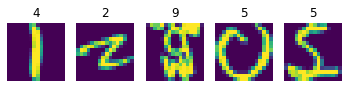

In [8]:
# K-Class Classifier Parameters:
Ker_Meth  = "Gau"
n_classes = 10
n_epochs  = 20

# Question 1b):
Testing_Error_per_run  = []
d_star_per_run         = []

# Question 1c):
confusion_matrix = []

# Question 1d):
prediction_mistake_count = np.zeros((Y_dataset.shape[0],1))

# Question 1b):
# Loop for 20 runs
for run in range(1,21):
    print("Run: {}".format(run))

    # 8:2 Split training + validation and testing set:
    # Index Shuffle for fitting:
    ran_sample_idx               = np.random.permutation(len(Y_dataset))
    split_pt                     = round(len(ran_sample_idx)*0.8)
    ran_trainvalidate_sample_idx = ran_sample_idx[:split_pt]
    ran_test_sample_idx          = ran_sample_idx[split_pt:len(ran_sample_idx)]
    n_train_validate_samples     = len(ran_trainvalidate_sample_idx)
    n_test_samples               = len(ran_test_sample_idx)
    
    # Q 1e, 2:
    c = [0.007, 0.0072, 0.0074, 0.0076, 0.0078, 0.008, 0.0082, 0.0084, 0.0086, 0.0088, 0.009]
    avg_validation_correct = []
    for Ker_para in c:
        print("c = {}".format(Ker_para))

        print("Precalculate Kernel...")
        KF  = KernelFunctor(Ker_Meth, Ker_para)
        tic = time.perf_counter()
        KN  = KF.kernel_fn(X_dataset) # Kernel matrix
        toc = time.perf_counter()
        print(f"**Kernel calculation finished in {toc - tic:0.4f} seconds")

        # 1b) 5 folds cross validation:
        validation_correct_all = []
        folds = 5
        for fold in range(0, folds):
            print(f"fold: {fold + 1}")

            # Get indicies for training set and validation set:
            data_train_idx, data_validate_idx = kFold(ran_trainvalidate_sample_idx, fold, folds)

            # Data sets:
            X_train              = X_dataset[data_train_idx]
            Y_train              = Y_dataset[data_train_idx]
            X_validate           = X_dataset[data_validate_idx]
            Y_validate           = Y_dataset[data_validate_idx]

            nsamples             = len(data_train_idx)

            # Initialize:
            alphas               = np.zeros((n_classes, nsamples))

            # Start Model:
            ovrop = OvR_OnlinePerceptron(alphas, KN, n_classes)

            for epoch in range(1, n_epochs + 1):
                tic    = time.time()
                alphas = ovrop.fit(data_train_idx, X_train, Y_train)
                toc    = time.time()
                
                print(f"**Training: Epoch {epoch} finished in {toc - tic:0.4f} seconds")
                epoch += 1
            
            # 1b) Validate:
            # ---------------Validation Accuracy-----------------
            validate_correct = 0

            kernel_vals      = KN[data_train_idx]
            kernel_vals      = kernel_vals[:, data_validate_idx]
            pred             = np.array(list(map(np.argmax, zip(*(alphas.dot(kernel_vals))))))
            validate_correct = len(np.where((Y_validate - pred) == 0)[0])
            
            # 1b )Record results:
            validation_correct_all.append(validate_correct)

        # 1b) Save all average validation correct for selection:
        avg_validation_correct.append(np.sum(validation_correct_all)/folds)
    
    # 1b) Select the best c (d*)
    d_star = c[np.argmax(avg_validation_correct)]

    # 1b) Retrain using d* on full 80% training set
    print(f"Retrain using c = {d_star}...")
    print("Precalculate Kernel...")
    KF  = KernelFunctor(Ker_Meth, d_star) # Use d_star
    tic = time.perf_counter()
    KN  = KF.kernel_fn(X_dataset) # Kernel matrix
    toc = time.perf_counter()
    print(f"**Kernel calculation finished in {toc - tic:0.4f} seconds")
    # Initialize:
    X_train_val = X_dataset[ran_trainvalidate_sample_idx]
    Y_train_val = Y_dataset[ran_trainvalidate_sample_idx]
    alphas = np.zeros((n_classes, n_train_validate_samples))
    
    # Start Model:
    ovrop = OvR_OnlinePerceptron(alphas, KN, n_classes)
    
    for epoch in range(1, n_epochs + 1):
        tic    = time.time()
        alphas = ovrop.fit(ran_trainvalidate_sample_idx, X_train_val, Y_train_val) # Full 80%
        toc    = time.time()
        
        print(f"**Training: Epoch {epoch} finished in {toc - tic:0.4f} seconds")
        epoch += 1
    
    # 1b) Test on testing set:
    # ---------------Testing Accuracy-------------------
    print("Testing...")
    X_test       = X_dataset[ran_test_sample_idx]
    Y_test       = Y_dataset[ran_test_sample_idx]
    Test_correct = 0

    kernel_vals  = KN[ran_trainvalidate_sample_idx]
    kernel_vals  = kernel_vals[:, ran_test_sample_idx]
    pred         = np.array(list(map(np.argmax, zip(*(alphas.dot(kernel_vals))))))
    Test_correct = len(np.where((Y_test - pred) == 0)[0])

    # 1c) Fill confusion matrix:
    confusion_matrix_per_run = np.zeros((10,10)) # 0 - 9
    label_count = np.zeros((10,1))
    for i, j in zip(Y_test, pred):
        label_count[i] += 1
        if i != j:
            confusion_matrix_per_run[i,j] += 1
    confusion_matrix_per_run = confusion_matrix_per_run/label_count
    
    # 1b) Record test error and mean d*
    Test_error = (n_test_samples - Test_correct)/n_test_samples
    Testing_Error_per_run.append(Test_error)
    d_star_per_run.append(d_star)

    # 1c) Record confusion matrix:
    confusion_matrix.append(confusion_matrix_per_run)

    # 1d) 5 worst data:
    print("Prediction mistake count...")
    kernel_vals  = KN[ran_trainvalidate_sample_idx]
    pred         = np.array(list(map(np.argmax, zip(*(alphas.dot(kernel_vals))))))
    for i in range(Y_dataset.shape[0]):
        if Y_dataset[i] != pred[i]:
            prediction_mistake_count[i] += 1

# Question 1d):
worst_5_idx = np.argsort(-prediction_mistake_count.T)[0,:5]

print("Results 1b):")
print(f"Testing error per run: {Testing_Error_per_run}")
print(f"d* per run: {d_star_per_run}")
print(f"Mean and STD of testing error: {np.mean(Testing_Error_per_run)} +- {np.std(Testing_Error_per_run)}")
print(f"Mean and STD of d*: {np.mean(d_star_per_run)} +- {np.std(d_star_per_run)}")

print("\nResults 1c):")
print(f"Mean confusion matrix:")
print(np.mean(confusion_matrix, axis = 0))
print(f"STD confusion matrix:")
print(np.std(confusion_matrix, axis = 0))

print("\nResults 1d):")
plot_idx = 1
for idx in worst_5_idx:
    plt.subplot(1, 5, plot_idx)
    img = np.reshape(X_dataset[idx], (16,16))
    plt.imshow(img)
    plt.axis('off')
    plt.title('%d' % Y_dataset[idx])
    plot_idx += 1